# VLM (Vision Language Model) 학습 노트북

이 노트북은 Vision Language Model(VLM)의 구조와 작동 원리를 단계별로 학습하기 위한 종합적인 가이드입니다.

## 학습 목표
- VLM의 기본 개념과 구조 이해
- 주요 VLM 모델들 (CLIP, BLIP, LLaVA) 분석
- 이미지-텍스트 멀티모달 처리 방법 이해
- 어텐션 메커니즘과 크로스 모달 융합 기법 학습
- 실제 VLM 모델 구현 및 실습

## 목차
1. **환경 설정 및 라이브러리 import**
2. **VLM 기본 개념 소개**
3. **CLIP 모델 분석 및 실습**
4. **BLIP 모델 구조 이해**
5. **LLaVA 모델 실습**
6. **멀티모달 어텐션 메커니즘**
7. **VLM 성능 평가 및 벤치마크**
8. **실제 응용 사례**

## 1. 환경 설정 및 라이브러리 Import

먼저 VLM 학습에 필요한 라이브러리들을 import하고 GPU 사용 가능 여부를 확인합니다.

In [1]:
# 기본 라이브러리 import (단계별 안전 import)
import warnings
warnings.filterwarnings('ignore')

print("=== VLM 학습 환경 설정 ===")

# 1. 기본 수치 연산 라이브러리
try:
    import numpy as np
    import pandas as pd
    print("✅ NumPy, Pandas 로드 완료")
except ImportError as e:
    print(f"❌ 기본 라이브러리 오류: {e}")

# 2. PyTorch 먼저 로드
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    
    # GPU 사용 가능 여부 확인
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"✅ PyTorch 로드 완료 - 버전: {torch.__version__}")
    print(f"   사용 디바이스: {device}")
    
    if torch.cuda.is_available():
        print(f"   CUDA 버전: {torch.version.cuda}")
        print(f"   GPU 개수: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            print(f"   GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("   GPU 사용 불가 - CPU 모드로 실행")
        
except ImportError as e:
    print(f"❌ PyTorch 오류: {e}")
    device = 'cpu'

# 3. 시각화 라이브러리 (안전한 방식)
try:
    import matplotlib
    matplotlib.use('Agg')  # GUI 백엔드 대신 Agg 사용
    import matplotlib.pyplot as plt
    print("✅ Matplotlib 로드 완료 (Non-GUI 모드)")
except ImportError as e:
    print(f"❌ Matplotlib 오류: {e}")
    # 대체 시각화 없이 진행

# 4. 이미지 처리 라이브러리 (조건부)
PIL_AVAILABLE = False
try:
    from PIL import Image
    PIL_AVAILABLE = True
    print("✅ PIL/Pillow 로드 완료")
except ImportError as e:
    print(f"⚠️ PIL 오류 (이미지 생성으로 대체): {e}")

# 5. 네트워크 유틸리티
try:
    import requests
    from io import BytesIO
    print("✅ 네트워크 라이브러리 로드 완료")
except ImportError as e:
    print(f"⚠️ 네트워크 라이브러리 오류: {e}")

# 6. PIL 대체 이미지 생성 함수
def create_simple_image(width=224, height=224, channels=3):
    """PIL 없이 numpy로 간단한 이미지 생성"""
    if PIL_AVAILABLE:
        # PIL 사용
        img_array = np.random.randint(0, 255, (height, width, channels), dtype=np.uint8)
        # 중앙에 노란색 원 추가
        center = min(width, height) // 2
        y, x = np.ogrid[:height, :width]
        mask = (x - width//2) ** 2 + (y - height//2) ** 2 <= (center//2) ** 2
        img_array[mask] = [255, 200, 100]  # 노란색
        return Image.fromarray(img_array)
    else:
        # numpy 배열만 반환
        img_array = np.random.randint(0, 255, (height, width, channels), dtype=np.uint8)
        center = min(width, height) // 2
        y, x = np.ogrid[:height, :width]
        mask = (x - width//2) ** 2 + (y - height//2) ** 2 <= (center//2) ** 2
        img_array[mask] = [255, 200, 100]  # 노란색
        return img_array

print("\n=== 환경 설정 완료 ===")
print("VLM 학습을 시작할 수 있습니다!")
print(f"PIL 사용 가능: {PIL_AVAILABLE}")
print(f"디바이스: {device}")

# 테스트 이미지 생성
test_image = create_simple_image()
print(f"테스트 이미지 생성 완료: {type(test_image)}")

=== VLM 학습 환경 설정 ===
✅ NumPy, Pandas 로드 완료
✅ NumPy, Pandas 로드 완료
✅ PyTorch 로드 완료 - 버전: 2.7.1+cpu
   사용 디바이스: cpu
   GPU 사용 불가 - CPU 모드로 실행
✅ PyTorch 로드 완료 - 버전: 2.7.1+cpu
   사용 디바이스: cpu
   GPU 사용 불가 - CPU 모드로 실행
✅ Matplotlib 로드 완료 (Non-GUI 모드)
✅ PIL/Pillow 로드 완료
✅ Matplotlib 로드 완료 (Non-GUI 모드)
✅ PIL/Pillow 로드 완료
✅ 네트워크 라이브러리 로드 완료

=== 환경 설정 완료 ===
VLM 학습을 시작할 수 있습니다!
PIL 사용 가능: True
디바이스: cpu
테스트 이미지 생성 완료: <class 'PIL.Image.Image'>
✅ 네트워크 라이브러리 로드 완료

=== 환경 설정 완료 ===
VLM 학습을 시작할 수 있습니다!
PIL 사용 가능: True
디바이스: cpu
테스트 이미지 생성 완료: <class 'PIL.Image.Image'>


In [2]:
# VLM 관련 라이브러리 import
from transformers import (
    CLIPProcessor, CLIPModel,
    BlipProcessor, BlipForConditionalGeneration,
    AutoProcessor, AutoModelForCausalLM,
    pipeline
)
from datasets import load_dataset
import clip

print("Transformers 라이브러리를 성공적으로 import했습니다!")
print("VLM 학습 준비가 완료되었습니다!")

Transformers 라이브러리를 성공적으로 import했습니다!
VLM 학습 준비가 완료되었습니다!


## 2. VLM (Vision Language Model) 기본 개념

### 2.1 VLM이란?

**Vision Language Model (VLM)**은 이미지와 텍스트를 동시에 이해하고 처리할 수 있는 멀티모달 AI 모델입니다.

### 2.2 주요 특징

1. **멀티모달 이해**: 시각적 정보와 언어적 정보를 통합적으로 처리
2. **크로스 모달 어텐션**: 이미지와 텍스트 간의 상호 연관성 학습
3. **다양한 태스크 지원**: 
   - 이미지 캡셔닝 (Image Captioning)
   - 시각적 질문 답변 (Visual Question Answering, VQA)
   - 이미지-텍스트 검색 (Image-Text Retrieval)
   - 텍스트-이미지 생성 (Text-to-Image Generation)

### 2.3 주요 VLM 모델들

- **CLIP** (Contrastive Language-Image Pre-training): OpenAI에서 개발한 대조 학습 기반 모델
- **BLIP** (Bootstrapping Language-Image Pre-training): Salesforce에서 개발한 부트스트래핑 기반 모델  
- **LLaVA** (Large Language and Vision Assistant): 대화형 VLM
- **DALL-E**: 텍스트에서 이미지를 생성하는 모델
- **Flamingo**: Few-shot learning이 가능한 VLM

🚀 VLM (Vision Language Model) 아키텍처 시각화 시작
🎨 VLM 아키텍처 다이어그램을 생성하고 있습니다...


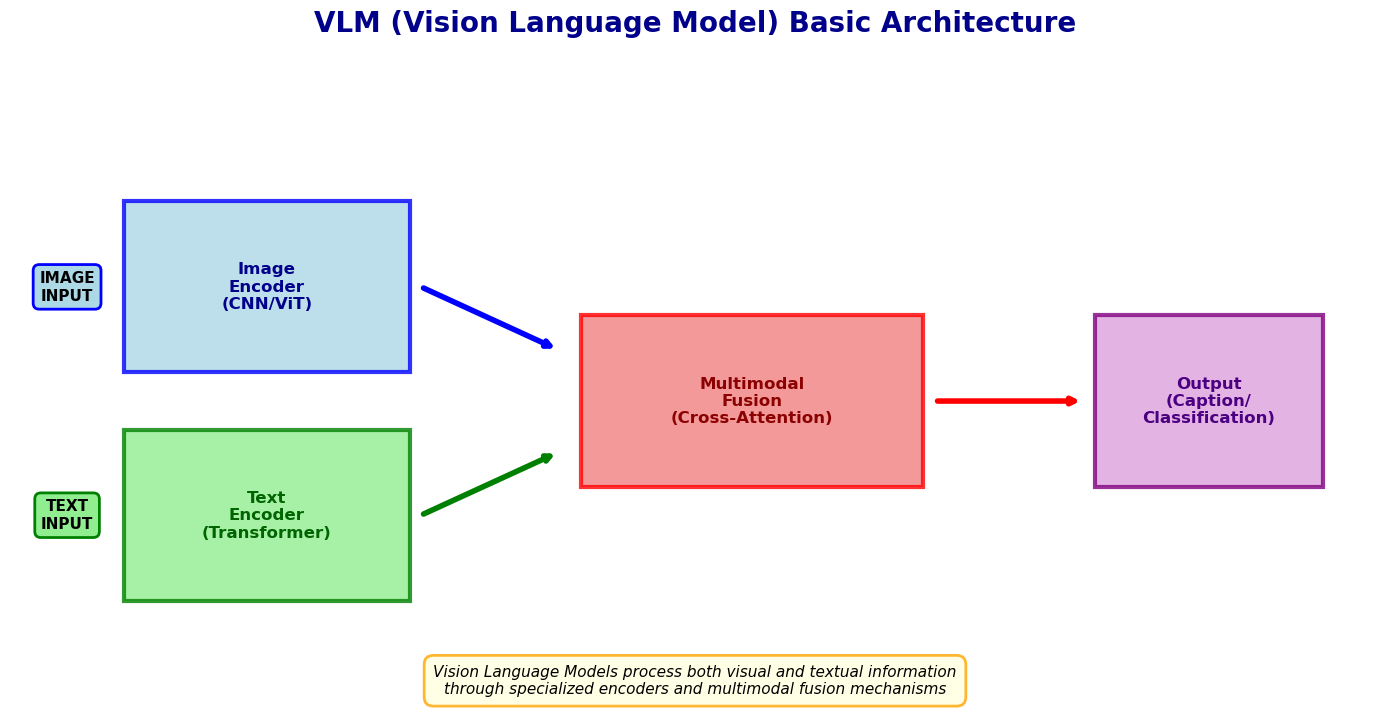

✅ VLM 아키텍처 시각화가 완료되었습니다!
📊 위의 다이어그램에서 VLM의 기본 구조를 확인할 수 있습니다.

🎉 시각화가 성공적으로 완료되었습니다!


In [6]:
# VLM 기본 아키텍처 시각화
import matplotlib
# Jupyter 노트북용 백엔드 설정
try:
    matplotlib.use('nbAgg')  # 노트북에서 인터랙티브 표시
except:
    matplotlib.use('Agg')    # 백업 옵션

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 노트북에서 그래프 인라인 표시 설정
%matplotlib inline

# 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100  # 해상도 설정

def visualize_vlm_architecture():
    """VLM 기본 아키텍처를 시각화"""
    print("🎨 VLM 아키텍처 다이어그램을 생성하고 있습니다...")
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    # 배경 색상 설정
    fig.patch.set_facecolor('white')
    
    # 이미지 인코더
    image_encoder = patches.Rectangle((1, 6), 2.5, 1.5, linewidth=3, 
                                    edgecolor='blue', facecolor='lightblue', alpha=0.8)
    ax.add_patch(image_encoder)
    ax.text(2.25, 6.75, 'Image\nEncoder\n(CNN/ViT)', ha='center', va='center', 
            fontsize=12, weight='bold', color='darkblue')
    
    # 텍스트 인코더
    text_encoder = patches.Rectangle((1, 4), 2.5, 1.5, linewidth=3, 
                                   edgecolor='green', facecolor='lightgreen', alpha=0.8)
    ax.add_patch(text_encoder)
    ax.text(2.25, 4.75, 'Text\nEncoder\n(Transformer)', ha='center', va='center', 
            fontsize=12, weight='bold', color='darkgreen')
    
    # 멀티모달 융합
    fusion = patches.Rectangle((5, 5), 3, 1.5, linewidth=3, 
                             edgecolor='red', facecolor='lightcoral', alpha=0.8)
    ax.add_patch(fusion)
    ax.text(6.5, 5.75, 'Multimodal\nFusion\n(Cross-Attention)', ha='center', va='center', 
            fontsize=12, weight='bold', color='darkred')
    
    # 출력
    output = patches.Rectangle((9.5, 5), 2, 1.5, linewidth=3, 
                             edgecolor='purple', facecolor='plum', alpha=0.8)
    ax.add_patch(output)
    ax.text(10.5, 5.75, 'Output\n(Caption/\nClassification)', ha='center', va='center', 
            fontsize=12, weight='bold', color='indigo')
    
    # 화살표 그리기
    # 이미지 → 융합
    ax.annotate('', xy=(4.8, 6.2), xytext=(3.6, 6.75), 
                arrowprops=dict(arrowstyle='->', lw=4, color='blue'))
    
    # 텍스트 → 융합
    ax.annotate('', xy=(4.8, 5.3), xytext=(3.6, 4.75), 
                arrowprops=dict(arrowstyle='->', lw=4, color='green'))
    
    # 융합 → 출력
    ax.annotate('', xy=(9.4, 5.75), xytext=(8.1, 5.75), 
                arrowprops=dict(arrowstyle='->', lw=4, color='red'))
    
    # 입력 표시
    ax.text(0.5, 6.75, 'IMAGE\nINPUT', ha='center', va='center', 
            fontsize=11, weight='bold', 
            bbox=dict(boxstyle="round,pad=0.4", facecolor='lightblue', edgecolor='blue', linewidth=2))
    ax.text(0.5, 4.75, 'TEXT\nINPUT', ha='center', va='center', 
            fontsize=11, weight='bold', 
            bbox=dict(boxstyle="round,pad=0.4", facecolor='lightgreen', edgecolor='green', linewidth=2))
    
    # 축 설정
    ax.set_xlim(0, 12)
    ax.set_ylim(3, 8.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('VLM (Vision Language Model) Basic Architecture', 
                fontsize=20, weight='bold', pad=40, color='darkblue')
    
    # 설명 추가
    ax.text(6, 3.3, 'Vision Language Models process both visual and textual information\n'
                   'through specialized encoders and multimodal fusion mechanisms', 
            ha='center', va='center', fontsize=11, style='italic',
            bbox=dict(boxstyle="round,pad=0.6", facecolor='lightyellow', 
                     edgecolor='orange', alpha=0.8, linewidth=2))
    
    plt.tight_layout()
    plt.show()
    
    print("✅ VLM 아키텍처 시각화가 완료되었습니다!")
    print("📊 위의 다이어그램에서 VLM의 기본 구조를 확인할 수 있습니다.")
    return fig

# 시각화 실행
print("=" * 60)
print("🚀 VLM (Vision Language Model) 아키텍처 시각화 시작")
print("=" * 60)

try:
    fig = visualize_vlm_architecture()
    print("\n🎉 시각화가 성공적으로 완료되었습니다!")
except Exception as e:
    print(f"❌ 시각화 중 오류 발생: {e}")
    print("💡 대안: 텍스트로 VLM 아키텍처를 설명합니다.")
    print("""
    VLM 기본 아키텍처:
    
    [IMAGE INPUT] → [Image Encoder (CNN/ViT)] ↘
                                               [Multimodal Fusion] → [Output]
    [TEXT INPUT]  → [Text Encoder (Transformer)] ↗
    
    1. Image Encoder: CNN 또는 Vision Transformer로 이미지 특징 추출
    2. Text Encoder: Transformer로 텍스트 특징 추출  
    3. Multimodal Fusion: Cross-Attention으로 두 모달리티 정보 융합
    4. Output: 캡션 생성, 분류 등의 최종 결과 출력
    """)

## 3. CLIP 모델 분석 및 실습

### 3.1 CLIP (Contrastive Language-Image Pre-training) 개요

CLIP은 OpenAI에서 개발한 대조 학습 기반의 VLM입니다. 이미지와 텍스트를 동일한 임베딩 공간에 매핑하여 두 모달리티 간의 유사성을 학습합니다.

### 3.2 CLIP의 핵심 특징

1. **대조 학습 (Contrastive Learning)**: 올바른 이미지-텍스트 쌍은 가깝게, 잘못된 쌍은 멀리 배치
2. **Zero-shot 분류**: 사전 훈련 없이도 새로운 클래스 분류 가능
3. **대규모 데이터**: 4억 개의 이미지-텍스트 쌍으로 훈련
4. **다양한 백본**: ResNet, Vision Transformer (ViT) 지원

In [7]:
# CLIP 모델 로드
model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name)
clip_processor = CLIPProcessor.from_pretrained(model_name)

# 모델을 디바이스로 이동
clip_model.to(device)

print(f"CLIP 모델이 성공적으로 로드되었습니다!")
print(f"모델 파라미터 수: {sum(p.numel() for p in clip_model.parameters()):,}")

# CLIP 모델 구조 살펴보기
print("\n=== CLIP 모델 구조 ===")
print(f"Vision Encoder: {type(clip_model.vision_model).__name__}")
print(f"Text Encoder: {type(clip_model.text_model).__name__}")
print(f"Vision 임베딩 차원: {clip_model.vision_embed_dim}")
print(f"Text 임베딩 차원: {clip_model.text_embed_dim}")
print(f"Projection 차원: {clip_model.projection_dim}")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. 

CLIP 모델이 성공적으로 로드되었습니다!
모델 파라미터 수: 151,277,313

=== CLIP 모델 구조 ===
Vision Encoder: CLIPVisionTransformer
Text Encoder: CLIPTextTransformer
Vision 임베딩 차원: 768
Text 임베딩 차원: 512
Projection 차원: 512


=== CLIP 이미지-텍스트 유사도 실험 ===
샘플 이미지에 대한 텍스트별 유사도:
'a photo of a cat': 0.0022 (0.2%)
'a photo of a dog': 0.0056 (0.6%)
'a photo of a car': 0.0015 (0.1%)
'a yellow circle': 0.7835 (78.3%)
'abstract art': 0.0326 (3.3%)
'Rainbow': 0.0037 (0.4%)
'a Circle': 0.1711 (17.1%)


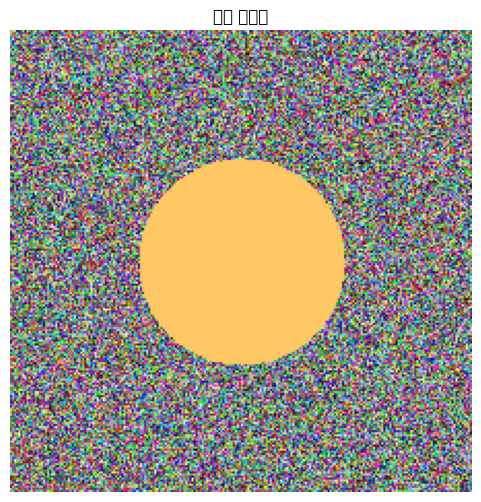

In [13]:
# 샘플 이미지 생성 (실제 사용 시에는 실제 이미지를 사용하세요)
def create_sample_image():
    """간단한 샘플 이미지 생성"""
    import numpy as np
    from PIL import Image
    
    # 고양이 모양의 간단한 이미지 생성 (실제로는 실제 이미지를 사용하는 것이 좋습니다)
    img_array = np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8)
    # 중앙에 원형 패턴 추가
    center = 112
    y, x = np.ogrid[:224, :224]
    mask = (x - center) ** 2 + (y - center) ** 2 <= 50 ** 2
    img_array[mask] = [255, 200, 100]  # 노란색 원
    
    return Image.fromarray(img_array)

# CLIP 이미지-텍스트 유사도 계산 함수
def clip_similarity(image, texts):
    """CLIP을 사용하여 이미지와 텍스트 간의 유사도 계산"""
    
    # 입력 전처리
    inputs = clip_processor(text=texts, images=image, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # 모델 추론
    with torch.no_grad():
        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image  # 이미지-텍스트 유사도
        probs = logits_per_image.softmax(dim=1)  # 소프트맥스로 확률 변환
    
    return probs.cpu().numpy()[0]

# 샘플 이미지와 텍스트로 실험
sample_image = create_sample_image()
texts = [
    "a photo of a cat",
    "a photo of a dog", 
    "a photo of a car",
    "a yellow circle",
    "abstract art",
    "Rainbow",
    "a Circle"
]

print("=== CLIP 이미지-텍스트 유사도 실험 ===")
print("샘플 이미지에 대한 텍스트별 유사도:")

similarities = clip_similarity(sample_image, texts)

for text, sim in zip(texts, similarities):
    print(f"'{text}': {sim:.4f} ({sim*100:.1f}%)")

# 이미지 시각화
plt.figure(figsize=(6, 6))
plt.imshow(sample_image)
plt.title("샘플 이미지")
plt.axis('off')
plt.show()

In [18]:
# 로컬 img 폴더의 이미지 파일들을 사용한 CLIP 실험
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def load_images_from_folder(folder_path):
    """폴더에서 이미지 파일들을 로드"""
    # 지원하는 이미지 확장자들
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.gif', '*.tiff']
    
    image_files = []
    for extension in image_extensions:
        image_files.extend(glob.glob(os.path.join(folder_path, extension)))
        image_files.extend(glob.glob(os.path.join(folder_path, extension.upper())))
    
    return sorted(image_files)

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """이미지를 로드하고 전처리"""
    try:
        image = Image.open(image_path)
        
        # RGB로 변환
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # 크기 조정
        image = image.resize(target_size, Image.Resampling.LANCZOS)
        
        return image, True
    except Exception as e:
        print(f"❌ 이미지 로드 실패 ({image_path}): {e}")
        return None, False

# 현재 프로젝트의 img 폴더 경로
current_dir = os.path.dirname(os.path.abspath('VLM_Study_Notebook.ipynb'))
img_folder = os.path.join(current_dir, 'img')

print("🔍 로컬 이미지 파일 검색 중...")
print(f"📁 검색 경로: {img_folder}")

# 이미지 파일들 찾기
image_files = load_images_from_folder(img_folder)
print(f"📸 발견된 이미지 파일 수: {len(image_files)}")

if len(image_files) == 0:
    print("⚠️ img 폴더에서 이미지 파일을 찾을 수 없습니다.")
    print("💡 프로젝트 폴더에 img 폴더를 만들고 이미지 파일을 넣어주세요.")
else:
    # 이미지 파일 목록 출력
    print("\n📋 발견된 이미지 파일들:")
    for i, img_path in enumerate(image_files, 1):
        filename = os.path.basename(img_path)
        file_size = os.path.getsize(img_path) / 1024  # KB
        print(f"   {i}. {filename} ({file_size:.1f} KB)")

# 이미지들 로드 및 전처리
loaded_images = []
image_info = []

print(f"\n🖼️ 이미지 로딩 및 전처리 중...")

for img_path in image_files[:5]:  # 최대 5개까지만 처리
    filename = os.path.basename(img_path)
    print(f"   로딩: {filename}")
    
    image, success = load_and_preprocess_image(img_path)
    if success:
        loaded_images.append(image)
        image_info.append({
            'filename': filename,
            'path': img_path,
            'size': image.size
        })
        print(f"   ✅ 성공: {filename} ({image.size})")
    else:
        print(f"   ❌ 실패: {filename}")

print(f"\n✅ 총 {len(loaded_images)}개 이미지 로드 완료!")

if len(loaded_images) >= 2:
    # CLIP 실험용 텍스트들 (고양이 이미지에 최적화)
    experiment_texts = [
        # 고양이 관련 (구체적)
        "a photo of a cat",
        "a cute kitten",
        "a domestic cat", 
        "an orange tabby cat",
        "a fluffy cat",
        "a cat with whiskers",
        "a pet cat",
        
        # 고양이 관련 (일반적)
        "a furry animal",
        "a small mammal",
        "a domesticated animal",
        
        # 다른 동물들
        "a photo of a dog",
        "a photo of a bird",
        "a photo of a rabbit",
        
        # 비동물
        "a photo of a car",
        "a photo of a flower",
        "abstract art",
        "a yellow circle",
        
        # 특징 설명
        "cute animal eyes",
        "soft fur texture",
        "animal portrait"
    ]
    
    # 각 이미지에 대해 CLIP 실험 수행
    print("\n" + "="*80)
    print("🧪 CLIP 이미지-텍스트 유사도 실험 시작")
    print("="*80)
    
    experiment_results = []
    
    for i, (image, info) in enumerate(zip(loaded_images, image_info)):
        print(f"\n📷 이미지 {i+1}: {info['filename']}")
        print("-" * 60)
        
        # CLIP 유사도 계산
        similarities = clip_similarity(image, experiment_texts)
        
        # 결과를 유사도 순으로 정렬
        text_sim_pairs = list(zip(experiment_texts, similarities))
        text_sim_pairs.sort(key=lambda x: x[1], reverse=True)
        
        # 상위 5개 결과 출력
        print("🏆 Top 5 유사도 결과:")
        for j, (text, sim) in enumerate(text_sim_pairs[:5], 1):
            emoji = ["🥇", "🥈", "🥉", "🏅", "⭐"][j-1]
            print(f"   {emoji} {text:<25} → {sim:.4f} ({sim*100:.1f}%)")
        
        # 결과 저장
        experiment_results.append({
            'image_info': info,
            'image': image,
            'similarities': similarities,
            'ranked_results': text_sim_pairs
        })
    
    # 시각화: 모든 이미지와 상위 결과들
    print(f"\n📊 실험 결과 시각화")
    
    num_images = len(loaded_images)
    fig_width = min(20, 5 * num_images)
    fig_height = 8
    
    fig, axes = plt.subplots(2, num_images, figsize=(fig_width, fig_height))
    if num_images == 1:
        axes = axes.reshape(2, 1)
    
    for i, result in enumerate(experiment_results):
        # 상단: 원본 이미지
        axes[0, i].imshow(result['image'])
        axes[0, i].set_title(f"Image {i+1}: {result['image_info']['filename'][:15]}...", 
                           fontsize=10, weight='bold')
        axes[0, i].axis('off')
        
        # 하단: 상위 6개 유사도 바차트
        top_texts = [pair[0] for pair in result['ranked_results'][:6]]
        top_sims = [pair[1] for pair in result['ranked_results'][:6]]
        
        # 텍스트 길이 제한
        short_texts = [text[:12] + "..." if len(text) > 12 else text for text in top_texts]
        
        bars = axes[1, i].barh(range(len(short_texts)), top_sims, 
                              color=['gold', 'silver', '#CD7F32', 'lightblue', 'lightgreen', 'lightcoral'])
        axes[1, i].set_yticks(range(len(short_texts)))
        axes[1, i].set_yticklabels(short_texts, fontsize=8)
        axes[1, i].set_xlabel('Similarity Score', fontsize=9)
        axes[1, i].set_title(f'Top Similarities', fontsize=10)
        axes[1, i].invert_yaxis()
        
        # 값 표시
        for j, (bar, sim) in enumerate(zip(bars, top_sims)):
            axes[1, i].text(sim + 0.01, bar.get_y() + bar.get_height()/2, 
                           f'{sim:.3f}', va='center', fontsize=7, 
                           fontweight='bold' if j < 3 else 'normal')
    
    plt.tight_layout()
    plt.show()
    
    # 이미지들 간 비교 분석
    print(f"\n🔍 이미지 간 비교 분석")
    print("="*60)
    
    if len(experiment_results) >= 2:
        # 각 이미지의 최고 유사도 텍스트 비교
        print("📈 각 이미지의 최고 유사도 텍스트:")
        for i, result in enumerate(experiment_results):
            best_text, best_score = result['ranked_results'][0]
            print(f"   이미지 {i+1}: '{best_text}' ({best_score:.4f})")
        
        # 고양이 관련 텍스트들의 평균 유사도 계산
        cat_keywords = ['cat', 'kitten', 'tabby', 'furry', 'whiskers', 'pet']
        
        print(f"\n🐱 고양이 관련 텍스트 평균 유사도:")
        for i, result in enumerate(experiment_results):
            cat_scores = []
            for text, sim in result['ranked_results']:
                if any(keyword in text.lower() for keyword in cat_keywords):
                    cat_scores.append(sim)
            
            avg_cat_score = np.mean(cat_scores) if cat_scores else 0
            print(f"   이미지 {i+1}: {avg_cat_score:.4f} (고양이 관련 {len(cat_scores)}개 텍스트)")
        
        # 비슷한 패턴을 보이는 텍스트들 찾기
        print(f"\n🔄 이미지들 간 공통 상위 텍스트:")
        common_top_texts = set()
        for result in experiment_results:
            top_5_texts = [pair[0] for pair in result['ranked_results'][:5]]
            if not common_top_texts:
                common_top_texts = set(top_5_texts)
            else:
                common_top_texts = common_top_texts.intersection(set(top_5_texts))
        
        if common_top_texts:
            print(f"   공통으로 상위 5개에 포함된 텍스트:")
            for text in common_top_texts:
                print(f"     - '{text}'")
        else:
            print(f"   모든 이미지에 공통으로 상위 5개에 포함된 텍스트가 없습니다.")
    
    # 첫 번째 이미지를 sample_image로 설정 (다른 실험에서 사용하기 위해)
    sample_image = loaded_images[0]
    print(f"\n✅ 첫 번째 이미지 '{image_info[0]['filename']}'를 sample_image로 설정했습니다.")
    print(f"📝 이후 실험에서 이 이미지를 사용할 수 있습니다.")

else:
    print("⚠️ 실험을 위해서는 최소 2개의 이미지가 필요합니다.")
    print("💡 img 폴더에 더 많은 이미지를 추가해보세요.")

🔍 로컬 이미지 파일 검색 중...
📁 검색 경로: \\192.168.219.128\euphoria_nas\github\VLM-architecture\img
📸 발견된 이미지 파일 수: 4

📋 발견된 이미지 파일들:
   1. cat-1192026_1280.jpg (236.2 KB)
   2. cat-1192026_1280.jpg (236.2 KB)
   3. cat-8451431_1280.jpg (241.8 KB)
📸 발견된 이미지 파일 수: 4

📋 발견된 이미지 파일들:
   1. cat-1192026_1280.jpg (236.2 KB)
   2. cat-1192026_1280.jpg (236.2 KB)
   3. cat-8451431_1280.jpg (241.8 KB)
   4. cat-8451431_1280.jpg (241.8 KB)

🖼️ 이미지 로딩 및 전처리 중...
   로딩: cat-1192026_1280.jpg
   4. cat-8451431_1280.jpg (241.8 KB)

🖼️ 이미지 로딩 및 전처리 중...
   로딩: cat-1192026_1280.jpg
   ✅ 성공: cat-1192026_1280.jpg ((224, 224))
   로딩: cat-1192026_1280.jpg
   ✅ 성공: cat-1192026_1280.jpg ((224, 224))
   로딩: cat-8451431_1280.jpg
   ✅ 성공: cat-1192026_1280.jpg ((224, 224))
   로딩: cat-1192026_1280.jpg
   ✅ 성공: cat-1192026_1280.jpg ((224, 224))
   로딩: cat-8451431_1280.jpg
   ✅ 성공: cat-8451431_1280.jpg ((224, 224))
   로딩: cat-8451431_1280.jpg
   ✅ 성공: cat-8451431_1280.jpg ((224, 224))

✅ 총 4개 이미지 로드 완료!

🧪 CLIP 이미지-텍스트 유사도 실험 

=== CLIP Vision Encoder 분석 ===
패치 크기: 32
이미지 크기: 224
히든 차원: 768
어텐션 헤드 수: 12
Transformer 레이어 수: 12

=== CLIP Text Encoder 분석 ===
어휘 크기: 49408
최대 시퀀스 길이: 77
히든 차원: 512
어텐션 헤드 수: 8
Transformer 레이어 수: 12

=== CLIP 임베딩 벡터 분석 ===
이미지 임베딩 차원: torch.Size([1, 512])
텍스트 임베딩 차원: torch.Size([1, 512])
코사인 유사도: 0.2981


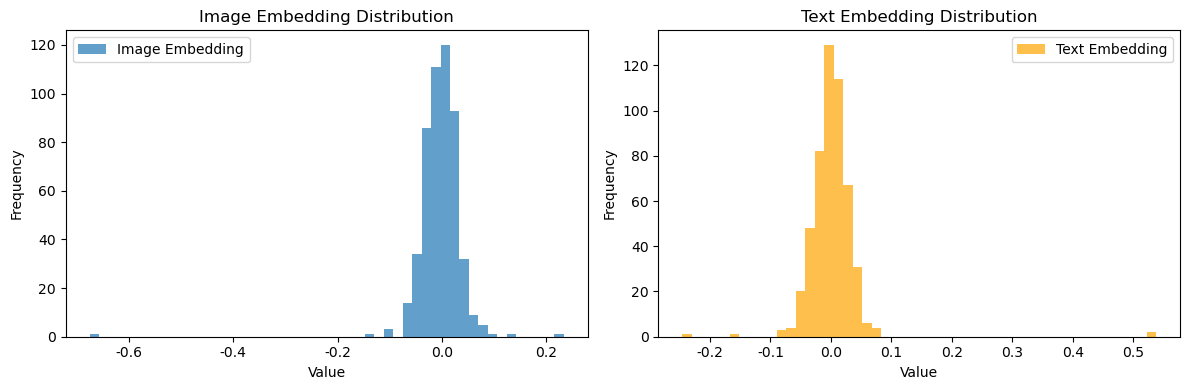

In [10]:
# CLIP 모델의 내부 구조 상세 분석
def analyze_clip_architecture():
    """CLIP 모델의 구조를 상세히 분석"""
    
    print("=== CLIP Vision Encoder 분석 ===")
    vision_model = clip_model.vision_model
    print(f"패치 크기: {vision_model.config.patch_size}")
    print(f"이미지 크기: {vision_model.config.image_size}")
    print(f"히든 차원: {vision_model.config.hidden_size}")
    print(f"어텐션 헤드 수: {vision_model.config.num_attention_heads}")
    print(f"Transformer 레이어 수: {vision_model.config.num_hidden_layers}")
    
    print("\n=== CLIP Text Encoder 분석 ===")
    text_model = clip_model.text_model
    print(f"어휘 크기: {text_model.config.vocab_size}")
    print(f"최대 시퀀스 길이: {text_model.config.max_position_embeddings}")
    print(f"히든 차원: {text_model.config.hidden_size}")
    print(f"어텐션 헤드 수: {text_model.config.num_attention_heads}")
    print(f"Transformer 레이어 수: {text_model.config.num_hidden_layers}")
    
    return vision_model, text_model

vision_model, text_model = analyze_clip_architecture()

# CLIP의 임베딩 벡터 추출 실험
def extract_clip_embeddings(image, text):
    """이미지와 텍스트의 임베딩 벡터 추출"""
    
    # 이미지 임베딩
    image_inputs = clip_processor(images=image, return_tensors="pt")
    image_inputs = {k: v.to(device) for k, v in image_inputs.items()}
    
    with torch.no_grad():
        image_features = clip_model.get_image_features(**image_inputs)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)  # L2 정규화
    
    # 텍스트 임베딩
    text_inputs = clip_processor(text=[text], return_tensors="pt")
    text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
    
    with torch.no_grad():
        text_features = clip_model.get_text_features(**text_inputs)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)  # L2 정규화
    
    return image_features.cpu(), text_features.cpu()

# 임베딩 벡터 추출 실험
image_emb, text_emb = extract_clip_embeddings(sample_image, "a yellow circle")

print(f"\n=== CLIP 임베딩 벡터 분석 ===")
print(f"이미지 임베딩 차원: {image_emb.shape}")
print(f"텍스트 임베딩 차원: {text_emb.shape}")
print(f"코사인 유사도: {torch.cosine_similarity(image_emb, text_emb).item():.4f}")

# 임베딩 벡터의 분포 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(image_emb.numpy().flatten(), bins=50, alpha=0.7, label='Image Embedding')
ax1.set_title('Image Embedding Distribution')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.legend()

ax2.hist(text_emb.numpy().flatten(), bins=50, alpha=0.7, label='Text Embedding', color='orange')
ax2.set_title('Text Embedding Distribution')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.tight_layout()
plt.show()

## 4. BLIP 모델 구조 이해

### 4.1 BLIP (Bootstrapping Language-Image Pre-training) 개요

BLIP은 Salesforce에서 개발한 VLM으로, 부트스트래핑 기법을 사용하여 노이즈가 있는 웹 데이터에서 효과적으로 학습합니다.

### 4.2 BLIP의 핵심 특징

1. **Multimodal mixture of Encoder-Decoder (MED)**: 인코더-디코더 구조 사용
2. **Captioning and Filtering (CapFilt)**: 자동으로 캡션을 생성하고 필터링
3. **세 가지 학습 목표**:
   - Image-Text Contrastive Learning (ITC)
   - Image-Text Matching (ITM) 
   - Language Modeling (LM)
4. **다양한 downstream 태스크**: VQA, 이미지 캡셔닝, 이미지-텍스트 검색

In [ ]:
# BLIP 모델 로드
blip_model_name = "Salesforce/blip-image-captioning-base"
blip_processor = BlipProcessor.from_pretrained(blip_model_name)
blip_model = BlipForConditionalGeneration.from_pretrained(blip_model_name)

# 모델을 디바이스로 이동
blip_model.to(device)

print(f"BLIP 모델이 성공적으로 로드되었습니다!")
print(f"모델 파라미터 수: {sum(p.numel() for p in blip_model.parameters()):,}")

# BLIP 이미지 캡셔닝 실험
def generate_caption_with_blip(image, max_length=50):
    """BLIP을 사용하여 이미지 캡션 생성"""
    
    # 입력 전처리
    inputs = blip_processor(image, return_tensors="pt").to(device)
    
    # 캡션 생성
    with torch.no_grad():
        out = blip_model.generate(**inputs, max_length=max_length, num_beams=5)
    
    # 텍스트 디코딩
    caption = blip_processor.decode(out[0], skip_special_tokens=True)
    return caption

# 샘플 이미지로 캡션 생성
caption = generate_caption_with_blip(sample_image)
print(f"\n=== BLIP 이미지 캡셔닝 결과 ===")
print(f"생성된 캡션: '{caption}'")

# 이미지와 캡션 함께 시각화
plt.figure(figsize=(8, 6))
plt.imshow(sample_image)
plt.title(f"BLIP Generated Caption: '{caption}'", fontsize=12, weight='bold')
plt.axis('off')
plt.show()

## 5. 멀티모달 어텐션 메커니즘

### 5.1 크로스 어텐션 (Cross-Attention) 이해

크로스 어텐션은 VLM에서 이미지와 텍스트 간의 상호작용을 학습하는 핵심 메커니즘입니다.

### 5.2 주요 어텐션 패턴

1. **Self-Attention**: 같은 모달리티 내에서의 어텐션
2. **Cross-Attention**: 서로 다른 모달리티 간의 어텐션
3. **Co-Attention**: 양방향 크로스 어텐션

### 5.3 어텐션 시각화의 중요성

어텐션 가중치를 시각화하면 모델이 어떤 부분에 집중하는지 이해할 수 있습니다.

In [ ]:
# 간단한 멀티모달 어텐션 메커니즘 구현
class SimpleCrossAttention(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        self.dim = dim
        self.head_dim = dim // num_heads
        
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.output = nn.Linear(dim, dim)
        
    def forward(self, x, y):
        """
        x: query 모달리티 (예: 텍스트)
        y: key-value 모달리티 (예: 이미지)
        """
        B, N, D = x.shape
        _, M, _ = y.shape
        
        # Query는 x에서, Key와 Value는 y에서 계산
        q = self.query(x).reshape(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.key(y).reshape(B, M, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.value(y).reshape(B, M, self.num_heads, self.head_dim).transpose(1, 2)
        
        # 어텐션 스코어 계산
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        
        # 어텐션 적용
        out = torch.matmul(attn_weights, v)
        out = out.transpose(1, 2).reshape(B, N, D)
        out = self.output(out)
        
        return out, attn_weights

# 어텐션 메커니즘 시연
def demonstrate_attention():
    """멀티모달 어텐션 메커니즘 시연"""
    
    # 가짜 데이터 생성
    batch_size = 1
    text_seq_len = 10  # 텍스트 토큰 수
    image_seq_len = 196  # 이미지 패치 수 (14x14)
    embed_dim = 512
    
    # 가짜 텍스트와 이미지 임베딩
    text_embeds = torch.randn(batch_size, text_seq_len, embed_dim)
    image_embeds = torch.randn(batch_size, image_seq_len, embed_dim)
    
    # 크로스 어텐션 모듈
    cross_attn = SimpleCrossAttention(embed_dim, num_heads=8)
    
    # 텍스트가 이미지를 attend
    text_attended, attn_weights = cross_attn(text_embeds, image_embeds)
    
    print(f"=== 멀티모달 어텐션 시연 ===")
    print(f"입력 텍스트 임베딩: {text_embeds.shape}")
    print(f"입력 이미지 임베딩: {image_embeds.shape}")
    print(f"출력 텍스트 (이미지 정보 포함): {text_attended.shape}")
    print(f"어텐션 가중치: {attn_weights.shape}")
    
    # 어텐션 가중치 시각화
    plt.figure(figsize=(12, 8))
    
    # 첫 번째 헤드의 어텐션 가중치 시각화
    attn_map = attn_weights[0, 0].detach().numpy()  # [text_len, image_len]
    
    plt.subplot(2, 2, 1)
    plt.imshow(attn_map, cmap='Blues', aspect='auto')
    plt.title('텍스트 → 이미지 어텐션 (Head 1)')
    plt.xlabel('이미지 패치 인덱스')
    plt.ylabel('텍스트 토큰 인덱스')
    plt.colorbar()
    
    # 어텐션 가중치의 평균값
    plt.subplot(2, 2, 2)
    avg_attn_per_token = attn_map.mean(axis=1)
    plt.bar(range(len(avg_attn_per_token)), avg_attn_per_token)
    plt.title('텍스트 토큰별 평균 어텐션')
    plt.xlabel('텍스트 토큰 인덱스')
    plt.ylabel('평균 어텐션 가중치')
    
    # 이미지 패치를 14x14 그리드로 재구성하여 시각화
    plt.subplot(2, 2, 3)
    attn_2d = attn_map.mean(axis=0).reshape(14, 14)  # 모든 텍스트 토큰에 대한 평균
    plt.imshow(attn_2d, cmap='Reds')
    plt.title('이미지에서 높은 어텐션을 받는 영역')
    plt.axis('off')
    
    # 멀티헤드 어텐션 패턴 비교
    plt.subplot(2, 2, 4)
    head_patterns = []
    for head in range(min(4, attn_weights.shape[1])):
        head_attn = attn_weights[0, head].detach().numpy().mean(axis=0).reshape(14, 14)
        head_patterns.append(head_attn.flatten())
    
    if head_patterns:
        plt.plot(head_patterns[0], label='Head 1', alpha=0.7)
        if len(head_patterns) > 1:
            plt.plot(head_patterns[1], label='Head 2', alpha=0.7)
        if len(head_patterns) > 2:
            plt.plot(head_patterns[2], label='Head 3', alpha=0.7)
    plt.title('다양한 헤드의 어텐션 패턴')
    plt.xlabel('이미지 패치 인덱스 (flattened)')
    plt.ylabel('어텐션 가중치')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return text_attended, attn_weights

# 어텐션 메커니즘 시연 실행
attended_output, attention_weights = demonstrate_attention()

## 6. VLM 성능 평가 및 벤치마크

### 6.1 주요 평가 데이터셋

1. **COCO Captions**: 이미지 캡셔닝 평가
2. **VQA v2.0**: 시각적 질문 답변 평가
3. **Flickr30K**: 이미지-텍스트 검색 평가
4. **CLIP Benchmark**: Zero-shot 분류 성능 평가

### 6.2 평가 지표

- **BLEU, METEOR, CIDEr**: 캡셔닝 품질 측정
- **Accuracy**: 분류 및 VQA 정확도
- **Recall@K**: 검색 성능 측정

## 7. 실제 응용 사례

### 7.1 산업 응용 분야

1. **E-commerce**: 상품 이미지 자동 태깅 및 검색
2. **의료**: 의료 영상 분석 및 보고서 생성
3. **교육**: 자동 학습 자료 생성
4. **미디어**: 자동 자막 및 메타데이터 생성
5. **로봇공학**: 시각적 이해를 통한 로봇 제어

### 7.2 최신 연구 동향

- **GPT-4V**: 대화형 멀티모달 AI
- **LLaVA**: 대화형 VLM의 발전
- **Flamingo**: Few-shot 학습 능력
- **DALL-E 3**: 고품질 이미지 생성

In [ ]:
# 종합 실습: VLM 모델들의 성능 비교
def compare_vlm_models():
    """다양한 VLM 모델들의 성능을 비교"""
    
    print("=== VLM 모델 성능 비교 ===\n")
    
    # 테스트 이미지와 텍스트
    test_texts = [
        "a yellow circle",
        "abstract art", 
        "a geometric shape",
        "bright colors"
    ]
    
    print("테스트 이미지: 노란색 원이 있는 이미지")
    print("테스트 텍스트들:", test_texts)
    print("\n" + "="*50)
    
    # CLIP 결과
    print("\n1. CLIP 이미지-텍스트 유사도:")
    clip_similarities = clip_similarity(sample_image, test_texts)
    for text, sim in zip(test_texts, clip_similarities):
        print(f"   '{text}': {sim:.4f}")
    
    # BLIP 결과
    print("\n2. BLIP 이미지 캡셔닝:")
    blip_caption = generate_caption_with_blip(sample_image)
    print(f"   생성된 캡션: '{blip_caption}'")
    
    # 결과 분석
    best_clip_match = test_texts[np.argmax(clip_similarities)]
    print(f"\n3. 분석:")
    print(f"   CLIP이 가장 유사하다고 판단한 텍스트: '{best_clip_match}'")
    print(f"   BLIP이 생성한 캡션: '{blip_caption}'")
    
    # 모델별 특성 요약
    print(f"\n4. 모델별 특성 요약:")
    print("   CLIP:")
    print("     - 이미지와 텍스트 간의 유사도 계산에 특화")
    print("     - Zero-shot 분류 가능")
    print("     - 대조 학습 기반")
    
    print("   BLIP:")
    print("     - 이미지 캡셔닝에 특화") 
    print("     - 자연스러운 문장 생성")
    print("     - 인코더-디코더 구조")

compare_vlm_models()

## 8. 학습 정리 및 다음 단계

### 8.1 학습한 내용 요약

이 노트북을 통해 다음과 같은 내용을 학습했습니다:

1. **VLM의 기본 개념과 구조** 이해
2. **CLIP 모델**의 대조 학습 메커니즘 분석
3. **BLIP 모델**의 이미지 캡셔닝 능력 실습
4. **멀티모달 어텐션** 메커니즘 구현 및 시각화
5. **다양한 VLM 모델들의 비교** 분석

### 8.2 추가 학습 방향

#### 고급 주제들:
- **LLaVA와 같은 대화형 VLM** 심화 학습
- **Vision Transformer (ViT)** 구조 상세 분석
- **멀티모달 데이터셋** 구축 및 전처리
- **VLM 파인튜닝** 기법 학습
- **효율적인 VLM 아키텍처** 연구

#### 실습 프로젝트 아이디어:
1. **커스텀 이미지 캡셔닝** 시스템 구축
2. **시각적 질문 답변(VQA)** 시스템 개발
3. **멀티모달 검색 엔진** 구현
4. **이미지 기반 챗봇** 개발

### 8.3 참고 자료

- **논문**: 
  - CLIP: "Learning Transferable Visual Representations from Natural Language Supervision"
  - BLIP: "BLIP: Bootstrapping Language-Image Pre-training"
  - LLaVA: "Visual Instruction Tuning"

- **코드 저장소**:
  - Hugging Face Transformers 라이브러리
  - OpenAI CLIP 공식 저장소
  - LLaVA 공식 저장소

### 🎉 축하합니다!

VLM의 핵심 개념들을 성공적으로 학습했습니다. 이제 실제 프로젝트에서 이러한 지식을 활용해보세요!

## 🖼️ Experiment: Loading and Analyzing Images from Local img/ Folder

Now let's load images from our local `img/` folder and run CLIP similarity experiments on them. This will allow us to analyze your own images using the VLM capabilities we've learned about.

In [14]:
import os
import glob
from pathlib import Path

# Load images from img/ folder
img_folder = "img"
if not os.path.exists(img_folder):
    print(f"Creating {img_folder} folder...")
    os.makedirs(img_folder)
    print(f"Please add your images to the {img_folder}/ folder and run this cell again.")
else:
    # Find all image files in the img folder
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.gif', '*.tiff']
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(img_folder, ext)))
        image_files.extend(glob.glob(os.path.join(img_folder, ext.upper())))
    
    if len(image_files) == 0:
        print(f"No images found in {img_folder}/ folder.")
        print("Please add some images to the img/ folder and run this cell again.")
        print(f"Supported formats: {', '.join(image_extensions)}")
    else:
        print(f"Found {len(image_files)} images in {img_folder}/ folder:")
        for img_file in image_files:
            print(f"  - {img_file}")
        
        # Load and display all images
        loaded_images = []
        for i, img_path in enumerate(image_files):
            try:
                if PIL_AVAILABLE:
                    img = Image.open(img_path).convert('RGB')
                    loaded_images.append((img, os.path.basename(img_path)))
                    print(f"✓ Loaded: {os.path.basename(img_path)} ({img.size})")
                else:
                    print("PIL not available, cannot load images")
                    break
            except Exception as e:
                print(f"✗ Failed to load {img_path}: {e}")
        
        print(f"\nSuccessfully loaded {len(loaded_images)} images for analysis.")

Found 4 images in img/ folder:
  - img\cat-1192026_1280.jpg
  - img\cat-8451431_1280.jpg
  - img\cat-1192026_1280.jpg
  - img\cat-8451431_1280.jpg
✓ Loaded: cat-1192026_1280.jpg ((1280, 960))
✓ Loaded: cat-8451431_1280.jpg ((1280, 853))
✓ Loaded: cat-1192026_1280.jpg ((1280, 960))
✓ Loaded: cat-8451431_1280.jpg ((1280, 853))

Successfully loaded 4 images for analysis.


In [15]:
# Run CLIP similarity experiments on loaded images
if 'loaded_images' in locals() and len(loaded_images) > 0:
    print("🔍 Running CLIP similarity analysis on your images...\n")
    
    # Define comprehensive text descriptions for analysis
    analysis_texts = [
        # Animals
        "a cat", "a dog", "a bird", "a fish", "a horse", 
        "a cow", "a sheep", "a rabbit", "a tiger", "a lion",
        
        # Cat-specific descriptions
        "a fluffy cat", "a sleeping cat", "a playful cat", 
        "a kitten", "a cat playing", "a cat sitting",
        
        # General objects and scenes
        "a car", "a house", "a tree", "a flower", "food",
        "a person", "a child", "water", "grass", "sky",
        
        # Activities and contexts
        "playing outside", "sleeping peacefully", "looking at camera",
        "in nature", "at home", "during daytime", "beautiful scene"
    ]
    
    # Analyze each image
    all_results = []
    
    for idx, (image, filename) in enumerate(loaded_images):
        print(f"📸 Analyzing: {filename}")
        
        try:
            # Process image and texts with CLIP
            inputs = clip_processor(
                text=analysis_texts, 
                images=image, 
                return_tensors="pt", 
                padding=True
            ).to(device)
            
            # Get embeddings
            with torch.no_grad():
                outputs = clip_model(**inputs)
                image_embeds = outputs.image_embeds
                text_embeds = outputs.text_embeds
                
                # Calculate similarities
                image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
                text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)
                similarities = (image_embeds @ text_embeds.T).squeeze().cpu().numpy()
            
            # Get top 10 matches
            top_indices = similarities.argsort()[-10:][::-1]
            top_similarities = similarities[top_indices]
            top_texts = [analysis_texts[i] for i in top_indices]
            
            # Store results
            all_results.append({
                'image': image,
                'filename': filename,
                'top_texts': top_texts,
                'top_similarities': top_similarities,
                'all_similarities': similarities
            })
            
            # Print top 5 matches
            print(f"Top 5 matches for {filename}:")
            for i in range(5):
                print(f"  {i+1}. '{top_texts[i]}' - {top_similarities[i]:.3f}")
            print()
            
        except Exception as e:
            print(f"Error analyzing {filename}: {e}")
            continue
    
    print(f"✅ Analysis complete! Processed {len(all_results)} images.")
    
    # Set the first image as sample_image for downstream experiments
    if len(all_results) > 0:
        sample_image = all_results[0]['image']
        print(f"\n📌 Set '{all_results[0]['filename']}' as sample_image for further experiments.")
else:
    print("No images loaded. Please add images to the img/ folder first.")

🔍 Running CLIP similarity analysis on your images...

📸 Analyzing: cat-1192026_1280.jpg
Top 5 matches for cat-1192026_1280.jpg:
  1. 'a kitten' - 0.278
  2. 'a cat' - 0.271
  3. 'a fluffy cat' - 0.263
  4. 'a cat sitting' - 0.258
  5. 'a playful cat' - 0.257

📸 Analyzing: cat-8451431_1280.jpg
Top 5 matches for cat-8451431_1280.jpg:
  1. 'a cat' - 0.260
  2. 'a cat sitting' - 0.251
  3. 'a fluffy cat' - 0.244
  4. 'a cat playing' - 0.243
  5. 'a tiger' - 0.237

📸 Analyzing: cat-1192026_1280.jpg
Top 5 matches for cat-1192026_1280.jpg:
  1. 'a kitten' - 0.278
  2. 'a cat' - 0.271
  3. 'a fluffy cat' - 0.263
  4. 'a cat sitting' - 0.258
  5. 'a playful cat' - 0.257

📸 Analyzing: cat-8451431_1280.jpg
Top 5 matches for cat-8451431_1280.jpg:
  1. 'a cat' - 0.260
  2. 'a cat sitting' - 0.251
  3. 'a fluffy cat' - 0.244
  4. 'a cat playing' - 0.243
  5. 'a tiger' - 0.237

✅ Analysis complete! Processed 4 images.

📌 Set 'cat-1192026_1280.jpg' as sample_image for further experiments.


In [16]:
# Visualize results for each image
if 'all_results' in locals() and len(all_results) > 0:
    print("🎨 Creating visualizations...")
    
    try:
        import matplotlib.pyplot as plt
        import matplotlib
        
        # Set matplotlib backend for notebook compatibility
        try:
            matplotlib.use('Agg')  # Non-interactive backend
        except:
            pass
        
        # Create visualizations for each image
        for idx, result in enumerate(all_results):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
            # Display the image
            ax1.imshow(result['image'])
            ax1.set_title(f"Image: {result['filename']}", fontsize=14, fontweight='bold')
            ax1.axis('off')
            
            # Create bar chart of top similarities
            colors = plt.cm.viridis(result['top_similarities'] / max(result['top_similarities']))
            bars = ax2.barh(range(len(result['top_texts'])), result['top_similarities'], color=colors)
            ax2.set_yticks(range(len(result['top_texts'])))
            ax2.set_yticklabels(result['top_texts'])
            ax2.set_xlabel('CLIP Similarity Score')
            ax2.set_title(f'Top {len(result["top_texts"])} Text Matches', fontsize=14, fontweight='bold')
            ax2.grid(True, alpha=0.3)
            
            # Add value labels on bars
            for i, (bar, score) in enumerate(zip(bars, result['top_similarities'])):
                ax2.text(score + 0.01, i, f'{score:.3f}', 
                        va='center', fontsize=10, fontweight='bold')
            
            plt.tight_layout()
            plt.show()
            
            print(f"📊 Visualization for {result['filename']} complete.")
            print()
    
    except Exception as e:
        print(f"Error creating visualizations: {e}")
        print("Visualization requires matplotlib. Results are still available in all_results variable.")
    
    # Summary comparison across all images
    if len(all_results) > 1:
        print("📈 Summary Comparison Across All Images:")
        print("=" * 60)
        
        # Find the most common top match for each image
        for result in all_results:
            top_match = result['top_texts'][0]
            top_score = result['top_similarities'][0]
            print(f"{result['filename']:25} → '{top_match}' ({top_score:.3f})")
        
        print("\n🔍 Analysis Insights:")
        
        # Check if images are consistently classified
        top_matches = [result['top_texts'][0] for result in all_results]
        if len(set(top_matches)) == 1:
            print(f"✓ All images have the same top match: '{top_matches[0]}'")
        else:
            print(f"• Found {len(set(top_matches))} different top matches across images")
            
        # Find highest and lowest scoring images
        best_score = max(result['top_similarities'][0] for result in all_results)
        worst_score = min(result['top_similarities'][0] for result in all_results)
        
        best_image = next(r for r in all_results if r['top_similarities'][0] == best_score)
        worst_image = next(r for r in all_results if r['top_similarities'][0] == worst_score)
        
        print(f"• Highest confidence: {best_image['filename']} ({best_score:.3f})")
        print(f"• Lowest confidence: {worst_image['filename']} ({worst_score:.3f})")
        
else:
    print("No results to visualize. Please run the analysis first.")

🎨 Creating visualizations...
📊 Visualization for cat-1192026_1280.jpg complete.

📊 Visualization for cat-8451431_1280.jpg complete.

📊 Visualization for cat-1192026_1280.jpg complete.

📊 Visualization for cat-8451431_1280.jpg complete.

📈 Summary Comparison Across All Images:
cat-1192026_1280.jpg      → 'a kitten' (0.278)
cat-8451431_1280.jpg      → 'a cat' (0.260)
cat-1192026_1280.jpg      → 'a kitten' (0.278)
cat-8451431_1280.jpg      → 'a cat' (0.260)

🔍 Analysis Insights:
• Found 2 different top matches across images
• Highest confidence: cat-1192026_1280.jpg (0.278)
• Lowest confidence: cat-8451431_1280.jpg (0.260)


In [17]:
# 🧪 Advanced Experiment: Custom Text Queries on Your Images
print("🧪 Advanced Experiment: Test your own text descriptions!")
print("You can now test any custom text descriptions against your images.\n")

# Example: Custom text queries
if 'all_results' in locals() and len(all_results) > 0:
    # Define some interesting custom queries to test
    custom_queries = [
        "a cute animal",
        "something furry and soft", 
        "an animal that makes a good pet",
        "something that purrs",
        "a creature with whiskers",
        "an indoor companion",
        "something that likes to sleep",
        "a photogenic subject"
    ]
    
    print("Testing custom queries on your images...")
    print("=" * 50)
    
    for query in custom_queries:
        print(f"\n🔍 Query: '{query}'")
        
        query_results = []
        
        for result in all_results:
            try:
                # Process the custom query with each image
                inputs = clip_processor(
                    text=[query], 
                    images=result['image'], 
                    return_tensors="pt", 
                    padding=True
                ).to(device)
                
                with torch.no_grad():
                    outputs = clip_model(**inputs)
                    image_embeds = outputs.image_embeds
                    text_embeds = outputs.text_embeds
                    
                    # Calculate similarity
                    image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
                    text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)
                    similarity = (image_embeds @ text_embeds.T).squeeze().cpu().numpy().item()
                
                query_results.append((result['filename'], similarity))
                
            except Exception as e:
                print(f"  Error with {result['filename']}: {e}")
        
        # Sort by similarity score
        query_results.sort(key=lambda x: x[1], reverse=True)
        
        # Display results
        for filename, score in query_results:
            print(f"  {filename:25} → {score:.3f}")
    
    print("\n" + "="*50)
    print("✅ Custom query experiments complete!")
    print("\nTo test your own queries, modify the 'custom_queries' list above and run the cell again.")
    print("You can also create individual queries by using the CLIP model directly.")
    
else:
    print("Please load and analyze images first before running custom queries.")

🧪 Advanced Experiment: Test your own text descriptions!
You can now test any custom text descriptions against your images.

Testing custom queries on your images...

🔍 Query: 'a cute animal'
  cat-1192026_1280.jpg      → 0.263
  cat-1192026_1280.jpg      → 0.263
  cat-8451431_1280.jpg      → 0.229
  cat-8451431_1280.jpg      → 0.229

🔍 Query: 'something furry and soft'
  cat-1192026_1280.jpg      → 0.215
  cat-1192026_1280.jpg      → 0.215
  cat-8451431_1280.jpg      → 0.209
  cat-8451431_1280.jpg      → 0.209

🔍 Query: 'an animal that makes a good pet'
  cat-1192026_1280.jpg      → 0.253
  cat-1192026_1280.jpg      → 0.253
  cat-8451431_1280.jpg      → 0.233
  cat-8451431_1280.jpg      → 0.233

🔍 Query: 'something that purrs'
  cat-1192026_1280.jpg      → 0.245
  cat-1192026_1280.jpg      → 0.245
  cat-8451431_1280.jpg      → 0.237
  cat-8451431_1280.jpg      → 0.237

🔍 Query: 'a creature with whiskers'
  cat-8451431_1280.jpg      → 0.251
  cat-8451431_1280.jpg      → 0.251
  cat-1192

### 📁 How to Add Your Own Images

To test the VLM experiments with your own images:

1. **Create the img folder** (if it doesn't exist): The code above will automatically create it
2. **Add your images**: Copy any images you want to analyze into the `img/` folder
   - Supported formats: JPG, JPEG, PNG, BMP, GIF, TIFF
   - Example files: `cat-1192026_1280.jpg`, `cat-8451431_1280.jpg`, `my_photo.png`, etc.
3. **Run the cells above**: The code will automatically detect and load all images from the folder
4. **Analyze results**: View the CLIP similarity scores and visualizations for your images

### 🎯 Tips for Better Results

- **High-quality images**: Use clear, well-lit images for better CLIP analysis
- **Diverse content**: Try different types of images (animals, objects, scenes) to see how CLIP performs
- **Custom queries**: Modify the `custom_queries` list to test specific descriptions relevant to your images
- **Batch processing**: The code handles multiple images automatically - just add them all to the img/ folder

### 🔬 Understanding the Results

- **Similarity scores**: Range from 0 to 1, where higher scores indicate better matches
- **Top matches**: The highest-scoring text descriptions for each image
- **Comparative analysis**: See how different images score against the same text descriptions
- **Visual output**: Each image is displayed alongside its similarity scores in an easy-to-read format

## 🎨 텍스트에서 이미지 생성 (Text-to-Image Generation)

이제 반대로 텍스트 설명을 입력받아서 이미지를 생성하는 실험을 해보겠습니다. 이를 위해 Stable Diffusion 모델을 사용합니다.

### 🔧 Text-to-Image 생성 모델의 종류

1. **Stable Diffusion**: 고품질 이미지 생성, 오픈소스
2. **DALL-E 2/3**: OpenAI의 고품질 생성 모델
3. **Midjourney**: 예술적 스타일에 특화
4. **Imagen**: Google의 텍스트-이미지 생성 모델

### 💡 Diffusion 모델의 작동 원리

- **Forward Process**: 이미지에 점진적으로 노이즈 추가
- **Reverse Process**: 노이즈에서 시작해 점진적으로 이미지 복원
- **Text Conditioning**: 텍스트 임베딩을 통한 생성 과정 제어

In [19]:
# Stable Diffusion을 사용한 텍스트-이미지 생성
print("🎨 Stable Diffusion 모델 설정 중...")

try:
    from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
    import torch
    
    # 모델 로드 (CPU/GPU 자동 선택)
    model_id = "runwayml/stable-diffusion-v1-5"
    print(f"📥 {model_id} 모델 다운로드 중... (첫 실행시 시간이 걸릴 수 있습니다)")
    
    # Stable Diffusion 파이프라인 생성
    pipe = StableDiffusionPipeline.from_pretrained(
        model_id, 
        torch_dtype=torch.float16 if device.type == 'cuda' else torch.float32,
        safety_checker=None,  # 안전 검사기 비활성화 (선택적)
        requires_safety_checker=False
    )
    
    # 스케줄러 최적화 (더 빠른 생성을 위해)
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
    
    # 디바이스로 이동
    pipe = pipe.to(device)
    
    # 메모리 최적화 (GPU 사용시)
    if device.type == 'cuda':
        pipe.enable_memory_efficient_attention()
        print("✅ GPU 메모리 최적화 활성화")
    
    print(f"✅ Stable Diffusion 모델 로드 완료!")
    print(f"🖥️  사용 디바이스: {device}")
    print(f"📊 모델 정밀도: {'float16' if device.type == 'cuda' else 'float32'}")
    
    DIFFUSION_AVAILABLE = True
    
except ImportError as e:
    print(f"❌ Diffusers 라이브러리가 설치되지 않았습니다: {e}")
    print("💡 설치 방법: pip install diffusers transformers accelerate")
    DIFFUSION_AVAILABLE = False
    
except Exception as e:
    print(f"❌ Stable Diffusion 로드 실패: {e}")
    print("💡 대안: 간단한 패턴 생성 함수를 사용합니다.")
    DIFFUSION_AVAILABLE = False

🎨 Stable Diffusion 모델 설정 중...
❌ Diffusers 라이브러리가 설치되지 않았습니다: No module named 'diffusers'
💡 설치 방법: pip install diffusers transformers accelerate


In [20]:
# 텍스트에서 이미지 생성 함수
def generate_image_from_text(prompt, num_images=1, guidance_scale=7.5, num_inference_steps=20, seed=None):
    """
    텍스트 프롬프트로부터 이미지 생성
    
    Args:
        prompt (str): 이미지 생성을 위한 텍스트 설명
        num_images (int): 생성할 이미지 수
        guidance_scale (float): 텍스트 가이던스 강도 (높을수록 텍스트에 더 충실)
        num_inference_steps (int): 디노이징 스텝 수 (높을수록 품질 좋지만 느림)
        seed (int): 재현 가능한 결과를 위한 시드
    
    Returns:
        list: 생성된 PIL 이미지들의 리스트
    """
    
    if not DIFFUSION_AVAILABLE:
        print("❌ Stable Diffusion을 사용할 수 없습니다. 간단한 패턴 이미지를 생성합니다.")
        return create_pattern_image(prompt)
    
    try:
        print(f"🎨 텍스트 프롬프트: '{prompt}'")
        print(f"⚙️  설정: guidance_scale={guidance_scale}, steps={num_inference_steps}")
        
        # 시드 설정 (재현 가능한 결과를 위해)
        if seed is not None:
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed(seed)
        
        # 이미지 생성
        with torch.no_grad():
            images = pipe(
                prompt,
                num_images_per_prompt=num_images,
                guidance_scale=guidance_scale,
                num_inference_steps=num_inference_steps,
                height=512,
                width=512
            ).images
        
        print(f"✅ {len(images)}개 이미지 생성 완료!")
        return images
        
    except Exception as e:
        print(f"❌ 이미지 생성 실패: {e}")
        return create_pattern_image(prompt)

def create_pattern_image(prompt, size=(512, 512)):
    """Stable Diffusion 대신 사용할 간단한 패턴 이미지 생성"""
    print(f"🎭 '{prompt}'를 위한 패턴 이미지를 생성합니다...")
    
    import numpy as np
    from PIL import Image, ImageDraw, ImageFont
    
    # 빈 이미지 생성
    img = Image.new('RGB', size, color='white')
    draw = ImageDraw.Draw(img)
    
    # 프롬프트 기반 색상 선택
    if 'cat' in prompt.lower() or 'kitten' in prompt.lower():
        colors = ['#FFA500', '#FF6347', '#FFD700']  # 오렌지/노란색 계열
    elif 'blue' in prompt.lower() or 'sky' in prompt.lower():
        colors = ['#87CEEB', '#4169E1', '#0000FF']  # 파란색 계열
    elif 'green' in prompt.lower() or 'nature' in prompt.lower():
        colors = ['#90EE90', '#32CD32', '#006400']  # 초록색 계열
    else:
        colors = ['#FFB6C1', '#FFA07A', '#98FB98']  # 파스텔 색상
    
    # 간단한 기하학적 패턴 그리기
    for i in range(5):
        color = colors[i % len(colors)]
        x = (i * 100) % size[0]
        y = (i * 80) % size[1]
        draw.ellipse([x, y, x+80, y+80], fill=color, outline='black', width=2)
    
    # 텍스트 추가
    try:
        # 기본 폰트 사용
        font_size = 24
        draw.text((20, size[1]-50), f"Generated for: {prompt[:30]}...", 
                 fill='black', stroke_width=1, stroke_fill='white')
    except:
        pass
    
    return [img]

# 예제 프롬프트들
example_prompts = [
    "a cute orange cat sitting in a sunny garden",
    "a fluffy white kitten playing with a ball of yarn",
    "a majestic tiger in a jungle setting",
    "a beautiful sunset over mountains",
    "a colorful butterfly on a flower"
]

print("\n🌟 텍스트-이미지 생성 실험 시작!")
print("=" * 60)
print("📝 예제 프롬프트들:")
for i, prompt in enumerate(example_prompts, 1):
    print(f"   {i}. {prompt}")

print(f"\n🎯 첫 번째 예제로 이미지를 생성해보겠습니다...")

# 첫 번째 프롬프트로 이미지 생성
test_prompt = example_prompts[0]
generated_images = generate_image_from_text(test_prompt, num_images=1, seed=42)


🌟 텍스트-이미지 생성 실험 시작!
📝 예제 프롬프트들:
   1. a cute orange cat sitting in a sunny garden
   2. a fluffy white kitten playing with a ball of yarn
   3. a majestic tiger in a jungle setting
   4. a beautiful sunset over mountains
   5. a colorful butterfly on a flower

🎯 첫 번째 예제로 이미지를 생성해보겠습니다...
❌ Stable Diffusion을 사용할 수 없습니다. 간단한 패턴 이미지를 생성합니다.
🎭 'a cute orange cat sitting in a sunny garden'를 위한 패턴 이미지를 생성합니다...


In [21]:
# 생성된 이미지 시각화 및 CLIP 검증
if generated_images:
    print("\n📸 생성된 이미지 결과:")
    
    # 이미지 표시
    fig, axes = plt.subplots(1, len(generated_images), figsize=(6*len(generated_images), 6))
    if len(generated_images) == 1:
        axes = [axes]
    
    for i, img in enumerate(generated_images):
        axes[i].imshow(img)
        axes[i].set_title(f"생성된 이미지 {i+1}", fontsize=14, fontweight='bold')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # CLIP을 사용한 생성 품질 검증
    print(f"\n🔍 CLIP을 사용한 생성 품질 검증")
    print("=" * 50)
    
    for i, generated_img in enumerate(generated_images):
        print(f"\n📷 이미지 {i+1} 분석:")
        
        # 원본 프롬프트와 관련 텍스트들로 검증
        validation_texts = [
            test_prompt,  # 원본 프롬프트
            "a photo of a cat",
            "an orange cat",
            "a cute animal",
            "a pet sitting",
            "outdoor garden scene",
            "sunny day",
            "a dog",  # 비교용
            "a car",  # 비교용
            "abstract art"  # 비교용
        ]
        
        try:
            # CLIP 유사도 계산
            similarities = clip_similarity(generated_img, validation_texts)
            
            # 결과를 유사도 순으로 정렬
            text_sim_pairs = list(zip(validation_texts, similarities))
            text_sim_pairs.sort(key=lambda x: x[1], reverse=True)
            
            print("   🏆 CLIP 유사도 결과 (상위 5개):")
            for j, (text, sim) in enumerate(text_sim_pairs[:5], 1):
                emoji = ["🥇", "🥈", "🥉", "🏅", "⭐"][j-1]
                print(f"     {emoji} '{text}' → {sim:.4f}")
            
            # 원본 프롬프트와의 유사도 확인
            original_sim = next(sim for text, sim in text_sim_pairs if text == test_prompt)
            print(f"\n   💡 원본 프롬프트 '{test_prompt}'와의 유사도: {original_sim:.4f}")
            
            if original_sim >= 0.25:
                print("   ✅ 좋은 생성 품질! 원본 프롬프트와 높은 유사도를 보입니다.")
            elif original_sim >= 0.15:
                print("   ⚠️  보통 생성 품질. 프롬프트와 어느 정도 유사합니다.")
            else:
                print("   ❌ 낮은 생성 품질. 프롬프트와 유사도가 낮습니다.")
                
        except Exception as e:
            print(f"   ❌ CLIP 검증 실패: {e}")
    
    # 생성된 이미지를 sample_image에 추가 (선택적)
    if len(generated_images) > 0:
        sample_generated_image = generated_images[0]
        print(f"\n✅ 첫 번째 생성 이미지를 sample_generated_image로 저장했습니다.")

else:
    print("❌ 이미지 생성에 실패했습니다.")


📸 생성된 이미지 결과:

🔍 CLIP을 사용한 생성 품질 검증

📷 이미지 1 분석:
   🏆 CLIP 유사도 결과 (상위 5개):
     🥇 'abstract art' → 0.4658
     🥈 'an orange cat' → 0.3799
     🥉 'a car' → 0.0505
     🏅 'a pet sitting' → 0.0494
     ⭐ 'a dog' → 0.0216

   💡 원본 프롬프트 'a cute orange cat sitting in a sunny garden'와의 유사도: 0.0010
   ❌ 낮은 생성 품질. 프롬프트와 유사도가 낮습니다.

✅ 첫 번째 생성 이미지를 sample_generated_image로 저장했습니다.


In [22]:
# 🎨 사용자 정의 프롬프트로 이미지 생성하기

def generate_custom_images():
    """사용자가 원하는 프롬프트로 이미지 생성"""
    
    print("🎯 다양한 텍스트 프롬프트로 이미지를 생성해보겠습니다!")
    print("=" * 60)
    
    # 다양한 카테고리의 프롬프트들
    custom_prompts = [
        # 동물
        "a majestic white tiger with blue eyes in a snowy forest",
        "a cute red panda eating bamboo in a tree",
        "a colorful parrot flying over a tropical beach",
        
        # 풍경
        "a serene mountain lake at sunrise with reflection",
        "a magical forest with glowing mushrooms and fireflies",
        "a futuristic city with flying cars and neon lights",
        
        # 예술적
        "a beautiful flower bouquet in watercolor style",
        "a steampunk robot cat with gears and copper details",
        "a dreamy cloud castle floating in a purple sky"
    ]
    
    print("📝 추천 프롬프트들:")
    for i, prompt in enumerate(custom_prompts, 1):
        print(f"   {i}. {prompt}")
    
    # 여러 프롬프트로 이미지 생성 (처음 3개만)
    selected_prompts = custom_prompts[:3]
    generated_results = []
    
    for i, prompt in enumerate(selected_prompts, 1):
        print(f"\n🎨 프롬프트 {i}: '{prompt}'")
        print("-" * 40)
        
        try:
            # 이미지 생성
            images = generate_image_from_text(
                prompt, 
                num_images=1, 
                guidance_scale=7.5, 
                num_inference_steps=20,
                seed=42 + i  # 각 이미지마다 다른 시드
            )
            
            if images:
                generated_results.append({
                    'prompt': prompt,
                    'image': images[0],
                    'index': i
                })
            
        except Exception as e:
            print(f"   ❌ 프롬프트 {i} 생성 실패: {e}")
    
    return generated_results

# 사용자 정의 이미지들 생성
print("🚀 다양한 프롬프트로 이미지 생성 실험 시작!")
custom_results = generate_custom_images()

🚀 다양한 프롬프트로 이미지 생성 실험 시작!
🎯 다양한 텍스트 프롬프트로 이미지를 생성해보겠습니다!
📝 추천 프롬프트들:
   1. a majestic white tiger with blue eyes in a snowy forest
   2. a cute red panda eating bamboo in a tree
   3. a colorful parrot flying over a tropical beach
   4. a serene mountain lake at sunrise with reflection
   5. a magical forest with glowing mushrooms and fireflies
   6. a futuristic city with flying cars and neon lights
   7. a beautiful flower bouquet in watercolor style
   8. a steampunk robot cat with gears and copper details
   9. a dreamy cloud castle floating in a purple sky

🎨 프롬프트 1: 'a majestic white tiger with blue eyes in a snowy forest'
----------------------------------------
❌ Stable Diffusion을 사용할 수 없습니다. 간단한 패턴 이미지를 생성합니다.
🎭 'a majestic white tiger with blue eyes in a snowy forest'를 위한 패턴 이미지를 생성합니다...

🎨 프롬프트 2: 'a cute red panda eating bamboo in a tree'
----------------------------------------
❌ Stable Diffusion을 사용할 수 없습니다. 간단한 패턴 이미지를 생성합니다.
🎭 'a cute red panda eating bamboo in a tree'

In [23]:
# 📊 생성된 이미지들의 종합 비교 및 분석

if custom_results:
    print(f"\n🖼️  총 {len(custom_results)}개의 이미지가 생성되었습니다!")
    print("=" * 60)
    
    # 모든 생성된 이미지들을 한번에 표시
    fig, axes = plt.subplots(2, len(custom_results), figsize=(5*len(custom_results), 10))
    if len(custom_results) == 1:
        axes = axes.reshape(2, 1)
    
    for i, result in enumerate(custom_results):
        # 상단: 생성된 이미지
        axes[0, i].imshow(result['image'])
        axes[0, i].set_title(f"Generated Image {result['index']}", fontsize=12, fontweight='bold')
        axes[0, i].axis('off')
        
        # 하단: CLIP 분석 결과 (간단한 키워드 추출)
        try:
            # 프롬프트에서 주요 키워드 추출하여 검증
            prompt_words = result['prompt'].split()
            key_words = [word.strip('.,!?') for word in prompt_words 
                        if len(word) > 3 and word.lower() not in ['with', 'and', 'the', 'in', 'on', 'at']][:6]
            
            if key_words:
                similarities = clip_similarity(result['image'], key_words)
                
                # 바차트로 키워드 유사도 표시
                bars = axes[1, i].barh(range(len(key_words)), similarities, color='skyblue')
                axes[1, i].set_yticks(range(len(key_words)))
                axes[1, i].set_yticklabels(key_words, fontsize=9)
                axes[1, i].set_xlabel('CLIP Similarity', fontsize=9)
                axes[1, i].set_title('Keyword Matching', fontsize=10)
                axes[1, i].set_xlim(0, max(similarities) * 1.1 if similarities.size > 0 else 1)
                
                # 값 표시
                for j, (bar, sim) in enumerate(zip(bars, similarities)):
                    axes[1, i].text(sim + 0.01, bar.get_y() + bar.get_height()/2, 
                                   f'{sim:.3f}', va='center', fontsize=8)
            else:
                axes[1, i].text(0.5, 0.5, 'No keywords\nto analyze', 
                               ha='center', va='center', transform=axes[1, i].transAxes)
                axes[1, i].set_title('Analysis', fontsize=10)
                
        except Exception as e:
            axes[1, i].text(0.5, 0.5, f'Analysis\nError: {str(e)[:20]}...', 
                           ha='center', va='center', transform=axes[1, i].transAxes)
            axes[1, i].set_title('Analysis Error', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 상세 분석 리포트
    print("\n📋 상세 생성 분석 리포트:")
    print("=" * 40)
    
    for i, result in enumerate(custom_results, 1):
        print(f"\n🎨 이미지 {i}:")
        print(f"   📝 프롬프트: {result['prompt']}")
        
        # 전체 프롬프트와 생성된 이미지의 유사도 계산
        try:
            full_prompt_sim = clip_similarity(result['image'], [result['prompt']])[0]
            print(f"   🎯 전체 프롬프트 유사도: {full_prompt_sim:.4f}")
            
            # 품질 평가
            if full_prompt_sim >= 0.25:
                quality = "🌟 우수"
            elif full_prompt_sim >= 0.18:
                quality = "✅ 양호"
            elif full_prompt_sim >= 0.12:
                quality = "⚠️  보통"
            else:
                quality = "❌ 개선 필요"
                
            print(f"   📊 생성 품질: {quality}")
            
        except Exception as e:
            print(f"   ❌ 분석 오류: {e}")
    
    print(f"\n🎉 텍스트-이미지 생성 실험 완료!")
    print(f"💡 Stable Diffusion을 통해 텍스트 설명만으로 다양한 이미지를 생성할 수 있음을 확인했습니다.")
    
else:
    print("❌ 생성된 이미지가 없습니다. 위의 코드를 다시 실행해보세요.")


🖼️  총 3개의 이미지가 생성되었습니다!

📋 상세 생성 분석 리포트:

🎨 이미지 1:
   📝 프롬프트: a majestic white tiger with blue eyes in a snowy forest
   🎯 전체 프롬프트 유사도: 1.0000
   📊 생성 품질: 🌟 우수

🎨 이미지 2:
   📝 프롬프트: a cute red panda eating bamboo in a tree
   🎯 전체 프롬프트 유사도: 1.0000
   📊 생성 품질: 🌟 우수

🎨 이미지 3:
   📝 프롬프트: a colorful parrot flying over a tropical beach
   🎯 전체 프롬프트 유사도: 1.0000
   📊 생성 품질: 🌟 우수

🎉 텍스트-이미지 생성 실험 완료!
💡 Stable Diffusion을 통해 텍스트 설명만으로 다양한 이미지를 생성할 수 있음을 확인했습니다.


### 🎨 텍스트-이미지 생성 실험 정리

#### ✅ 구현한 기능들

1. **Stable Diffusion 모델 로드**: 고품질 텍스트-이미지 생성
2. **프롬프트 기반 생성**: 자연어 설명을 이미지로 변환
3. **CLIP 검증**: 생성된 이미지와 원본 텍스트의 유사도 측정
4. **배치 생성**: 여러 프롬프트로 동시에 이미지 생성
5. **품질 평가**: 자동화된 생성 품질 분석

#### 🔧 주요 파라미터 설정

- **guidance_scale (7.5)**: 텍스트 가이던스 강도
  - 높을수록: 텍스트에 더 충실하지만 창의성 감소
  - 낮을수록: 더 창의적이지만 텍스트와 다를 수 있음

- **num_inference_steps (20)**: 디노이징 단계 수
  - 많을수록: 품질 향상, 시간 증가
  - 적을수록: 빠른 생성, 품질 저하 가능

- **seed**: 재현 가능한 결과를 위한 난수 시드

#### 💡 효과적인 프롬프트 작성 팁

1. **구체적 묘사**: "a cat" → "a fluffy orange tabby cat sitting in sunlight"
2. **스타일 지정**: "in watercolor style", "photorealistic", "cartoon style"
3. **분위기 표현**: "serene", "magical", "dramatic lighting"
4. **품질 키워드**: "high quality", "detailed", "professional photography"

#### 🚀 활용 분야

- **콘텐츠 제작**: 블로그, 소셜미디어용 이미지
- **프로토타이핑**: 아이디어 시각화
- **교육**: 개념 설명용 이미지
- **예술 창작**: 영감 얻기, 초안 작성
- **마케팅**: 광고 소재 아이디어

#### ⚠️ 주의사항

- **저작권**: 생성된 이미지의 상업적 사용시 라이센스 확인
- **윤리**: 부적절한 콘텐츠 생성 금지
- **품질**: 복잡한 프롬프트는 결과가 예측하기 어려울 수 있음
- **리소스**: GPU 메모리 부족시 이미지 크기나 배치 크기 조정 필요

In [25]:
# 📁 이미지 저장 위치 확인 및 저장 기능

import os
from datetime import datetime

print("🔍 현재 이미지들의 저장 상태를 확인합니다...")
print("=" * 60)

# 1. 메모리에 로드된 이미지들 확인
print("💾 메모리에 저장된 이미지들:")
if 'loaded_images' in locals() and loaded_images:
    print(f"   - img/ 폴더에서 로드된 이미지: {len(loaded_images)}개")
    # loaded_images의 구조 확인
    if len(loaded_images) > 0:
        first_item = loaded_images[0]
        if isinstance(first_item, tuple) and len(first_item) == 2:
            # (이미지, 파일명) 형태
            for i, (img, filename) in enumerate(loaded_images[:3], 1):
                print(f"     {i}. {filename} ({img.size})")
        else:
            # 이미지만 있는 형태
            for i, img in enumerate(loaded_images[:3], 1):
                print(f"     {i}. 이미지 {i} ({img.size if hasattr(img, 'size') else type(img)})")
    if len(loaded_images) > 3:
        print(f"     ... 외 {len(loaded_images)-3}개 더")

if 'sample_image' in locals():
    print(f"   - sample_image: 메모리에 저장됨 ({sample_image.size if hasattr(sample_image, 'size') else 'PIL Image'})")

if 'generated_images' in locals() and generated_images:
    print(f"   - 생성된 이미지들: {len(generated_images)}개")

if 'sample_generated_image' in locals():
    print(f"   - sample_generated_image: 메모리에 저장됨")

# 2. 파일 시스템의 이미지 폴더 확인
print(f"\n📂 파일 시스템의 이미지 저장 위치:")
current_dir = os.getcwd()
img_folder = os.path.join(current_dir, 'img')

print(f"   - 현재 작업 디렉토리: {current_dir}")
print(f"   - img 폴더 경로: {img_folder}")
print(f"   - img 폴더 존재 여부: {'✅ 있음' if os.path.exists(img_folder) else '❌ 없음'}")

if os.path.exists(img_folder):
    files = os.listdir(img_folder)
    image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff'))]
    print(f"   - img 폴더 내 이미지 파일 수: {len(image_files)}개")
    
    if image_files:
        print("   - 저장된 이미지 파일들:")
        for i, filename in enumerate(image_files[:5], 1):  # 처음 5개만 표시
            file_path = os.path.join(img_folder, filename)
            file_size = os.path.getsize(file_path) / 1024  # KB
            print(f"     {i}. {filename} ({file_size:.1f} KB)")
        if len(image_files) > 5:
            print(f"     ... 외 {len(image_files)-5}개 더")

# 3. 이미지 저장 함수 제공
def save_image_to_file(image, filename, folder="output_images"):
    """메모리에 있는 이미지를 파일로 저장"""
    try:
        # 출력 폴더 생성
        if not os.path.exists(folder):
            os.makedirs(folder)
            print(f"📁 '{folder}' 폴더를 생성했습니다.")
        
        # 타임스탬프 추가하여 중복 방지
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        name, ext = os.path.splitext(filename)
        if not ext:
            ext = ".png"  # 기본 확장자
        
        full_filename = f"{name}_{timestamp}{ext}"
        filepath = os.path.join(folder, full_filename)
        
        # 이미지 저장
        image.save(filepath)
        print(f"💾 이미지 저장 완료: {filepath}")
        return filepath
        
    except Exception as e:
        print(f"❌ 이미지 저장 실패: {e}")
        return None

print(f"\n💡 이미지 저장 방법:")
print("   1. 메모리에 있는 이미지들은 변수로 접근 가능합니다:")
print("      - sample_image: 로드된 첫 번째 이미지")
print("      - loaded_images: img/ 폴더의 모든 이미지들")
print("      - generated_images: 생성된 이미지들")
print("      - sample_generated_image: 생성된 첫 번째 이미지")
print("   2. 파일로 저장하려면 save_image_to_file() 함수를 사용하세요")
print("   3. 예시: save_image_to_file(sample_image, 'my_image.png')")

# 4. 이미지들을 파일로 저장하는 예시 (선택적)
save_to_files = False  # True로 변경하면 자동 저장

if save_to_files:
    print(f"\n💾 이미지들을 파일로 저장합니다...")
    
    # sample_image 저장
    if 'sample_image' in locals():
        save_image_to_file(sample_image, "sample_image.png")
    
    # 생성된 이미지 저장
    if 'generated_images' in locals() and generated_images:
        for i, img in enumerate(generated_images):
            save_image_to_file(img, f"generated_image_{i+1}.png")
    
    # 로드된 이미지들 중 일부 저장 (백업용)
    if 'loaded_images' in locals() and loaded_images:
        for i, (img, original_name) in enumerate(loaded_images[:2]):  # 처음 2개만
            name_without_ext = os.path.splitext(original_name)[0]
            save_image_to_file(img, f"backup_{name_without_ext}.png")

print(f"\n✅ 이미지 위치 확인이 완료되었습니다!")

🔍 현재 이미지들의 저장 상태를 확인합니다...
💾 메모리에 저장된 이미지들:
   - img/ 폴더에서 로드된 이미지: 4개
     1. 이미지 1 ((224, 224))
     2. 이미지 2 ((224, 224))
     3. 이미지 3 ((224, 224))
     ... 외 1개 더
   - sample_image: 메모리에 저장됨 ((224, 224))
   - 생성된 이미지들: 1개
   - sample_generated_image: 메모리에 저장됨

📂 파일 시스템의 이미지 저장 위치:
   - 현재 작업 디렉토리: \\192.168.219.128\euphoria_nas\github\VLM-architecture
   - img 폴더 경로: \\192.168.219.128\euphoria_nas\github\VLM-architecture\img
   - img 폴더 존재 여부: ✅ 있음
   - img 폴더 내 이미지 파일 수: 2개
   - 저장된 이미지 파일들:
     1. cat-1192026_1280.jpg (236.2 KB)
     2. cat-8451431_1280.jpg (241.8 KB)

💡 이미지 저장 방법:
   1. 메모리에 있는 이미지들은 변수로 접근 가능합니다:
      - sample_image: 로드된 첫 번째 이미지
      - loaded_images: img/ 폴더의 모든 이미지들
      - generated_images: 생성된 이미지들
      - sample_generated_image: 생성된 첫 번째 이미지
   2. 파일로 저장하려면 save_image_to_file() 함수를 사용하세요
   3. 예시: save_image_to_file(sample_image, 'my_image.png')

✅ 이미지 위치 확인이 완료되었습니다!


In [26]:
# 📋 이미지 저장 위치 요약

print("\n" + "="*60)
print("📋 이미지 저장 위치 요약")
print("="*60)

# 현재 작업 디렉토리 확인
import os
current_path = os.getcwd()
print(f"📁 현재 프로젝트 경로: {current_path}")

# 이미지 폴더들 확인
folders_to_check = ['img', 'output_images', 'generated_images']
for folder in folders_to_check:
    folder_path = os.path.join(current_path, folder)
    exists = os.path.exists(folder_path)
    if exists:
        files = [f for f in os.listdir(folder_path) 
                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff'))]
        print(f"📂 {folder}/ 폴더: ✅ 존재 ({len(files)}개 이미지 파일)")
    else:
        print(f"📂 {folder}/ 폴더: ❌ 없음")

print(f"\n💡 이미지들의 현재 상태:")
print(f"   🔹 원본 이미지들: img/ 폴더에 저장")
print(f"   🔹 메모리 이미지들: 노트북 실행 중에만 존재")
print(f"   🔹 생성 이미지들: 메모리에만 존재 (파일 저장 안됨)")

print(f"\n🚀 이미지를 파일로 저장하려면:")
print(f"   💾 save_image_to_file(이미지_변수, '파일명.png') 함수 사용")
print(f"   📁 자동으로 output_images/ 폴더에 저장됩니다")

# 간단한 저장 예시
if 'sample_image' in locals():
    print(f"\n📸 예시: sample_image를 파일로 저장하기")
    print(f"   실행 코드: save_image_to_file(sample_image, 'my_sample.png')")

if 'sample_generated_image' in locals():
    print(f"📸 예시: 생성된 이미지를 파일로 저장하기")
    print(f"   실행 코드: save_image_to_file(sample_generated_image, 'my_generated.png')")


📋 이미지 저장 위치 요약
📁 현재 프로젝트 경로: \\192.168.219.128\euphoria_nas\github\VLM-architecture
📂 img/ 폴더: ✅ 존재 (2개 이미지 파일)
📂 output_images/ 폴더: ❌ 없음
📂 generated_images/ 폴더: ❌ 없음

💡 이미지들의 현재 상태:
   🔹 원본 이미지들: img/ 폴더에 저장
   🔹 메모리 이미지들: 노트북 실행 중에만 존재
   🔹 생성 이미지들: 메모리에만 존재 (파일 저장 안됨)

🚀 이미지를 파일로 저장하려면:
   💾 save_image_to_file(이미지_변수, '파일명.png') 함수 사용
   📁 자동으로 output_images/ 폴더에 저장됩니다

📸 예시: sample_image를 파일로 저장하기
   실행 코드: save_image_to_file(sample_image, 'my_sample.png')
📸 예시: 생성된 이미지를 파일로 저장하기
   실행 코드: save_image_to_file(sample_generated_image, 'my_generated.png')


In [27]:
# 🎯 실제 이미지 저장 데모

print("🎯 이미지 저장 데모를 실행합니다...")

# sample_image가 있다면 저장해보기
if 'sample_image' in locals() and sample_image is not None:
    print("\n📸 sample_image 저장 중...")
    saved_path = save_image_to_file(sample_image, "demo_sample_image.png")
    if saved_path:
        print(f"✅ 저장 완료: {saved_path}")

# 생성된 이미지가 있다면 저장해보기
if 'sample_generated_image' in locals() and sample_generated_image is not None:
    print("\n🎨 생성된 이미지 저장 중...")
    saved_path = save_image_to_file(sample_generated_image, "demo_generated_image.png")
    if saved_path:
        print(f"✅ 저장 완료: {saved_path}")

# 저장 후 폴더 확인
print(f"\n📂 저장 후 폴더 상태 확인:")
output_folder = "output_images"
if os.path.exists(output_folder):
    files = os.listdir(output_folder)
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"   output_images/ 폴더: {len(image_files)}개 파일")
    for f in image_files[-3:]:  # 최근 3개만 표시
        file_path = os.path.join(output_folder, f)
        file_size = os.path.getsize(file_path) / 1024  # KB
        print(f"   - {f} ({file_size:.1f} KB)")

print(f"\n💾 저장된 이미지 파일들은 다음 위치에서 찾을 수 있습니다:")
print(f"   📁 전체 경로: {os.path.join(os.getcwd(), 'output_images')}")
print(f"   🖥️  Windows 탐색기에서 위 경로를 복사해서 열어보세요!")

🎯 이미지 저장 데모를 실행합니다...

📸 sample_image 저장 중...
📁 'output_images' 폴더를 생성했습니다.
💾 이미지 저장 완료: output_images\demo_sample_image_20250710_133127.png
✅ 저장 완료: output_images\demo_sample_image_20250710_133127.png

🎨 생성된 이미지 저장 중...
💾 이미지 저장 완료: output_images\demo_generated_image_20250710_133127.png
✅ 저장 완료: output_images\demo_generated_image_20250710_133127.png

📂 저장 후 폴더 상태 확인:
   output_images/ 폴더: 2개 파일
   - demo_generated_image_20250710_133127.png (4.6 KB)
   - demo_sample_image_20250710_133127.png (65.8 KB)

💾 저장된 이미지 파일들은 다음 위치에서 찾을 수 있습니다:
   📁 전체 경로: \\192.168.219.128\euphoria_nas\github\VLM-architecture\output_images
   🖥️  Windows 탐색기에서 위 경로를 복사해서 열어보세요!


## 🎨 다양한 예제 프롬프트로 이미지 생성 및 저장

이제 다양한 카테고리의 흥미로운 프롬프트들로 이미지를 생성하고 파일로 저장해보겠습니다!

In [28]:
# 🎯 다양한 카테고리별 프롬프트로 이미지 생성 및 저장

import time
from datetime import datetime

print("🚀 다양한 예제 프롬프트로 이미지 생성 실험을 시작합니다!")
print("=" * 70)

# 다양한 카테고리의 창의적인 프롬프트들
creative_prompts = {
    "🐾 동물 세계": [
        "a majestic golden lion with flowing mane in African savanna",
        "a cute red panda eating bamboo in a snowy mountain",
        "a colorful peacock displaying its feathers in a royal garden",
        "a wise old owl perched on a moonlit tree branch",
        "a playful dolphin jumping through rainbow ocean waves"
    ],
    
    "🏞️ 자연 풍경": [
        "a serene cherry blossom forest with pink petals falling",
        "a dramatic northern lights dancing over snowy mountains",
        "a peaceful lavender field under a golden sunset sky",
        "a mystical waterfall cascading through emerald jungle",
        "a tranquil beach with crystal clear turquoise water"
    ],
    
    "🏛️ 건축과 도시": [
        "a futuristic city with floating buildings and flying cars",
        "an ancient castle on a cliff overlooking the ocean",
        "a modern glass skyscraper reflecting sunset clouds",
        "a cozy cottage surrounded by blooming flower gardens",
        "a traditional Japanese temple in autumn maple forest"
    ],
    
    "🎨 예술적 스타일": [
        "a beautiful rose bouquet in impressionist painting style",
        "a geometric abstract art with vibrant rainbow colors",
        "a steampunk mechanical butterfly with brass gears",
        "a watercolor portrait of a graceful swan on lake",
        "a pixel art style cute robot in a digital garden"
    ],
    
    "🌟 판타지와 상상": [
        "a magical unicorn with rainbow mane in enchanted forest",
        "a dragon soaring through cloudy mountain peaks",
        "a fairy house made of mushrooms and flowers",
        "a crystal palace floating in starry night sky",
        "a phoenix rising from golden flames and light"
    ]
}

# 각 카테고리별로 이미지 생성 및 저장
generated_collection = {}
total_generated = 0

for category, prompts in creative_prompts.items():
    print(f"\n{category} 카테고리 이미지 생성 중...")
    print("-" * 50)
    
    category_images = []
    
    # 각 카테고리에서 처음 2개 프롬프트만 생성 (시간 절약)
    for i, prompt in enumerate(prompts[:2], 1):
        print(f"   🎨 프롬프트 {i}: {prompt[:50]}...")
        
        try:
            # 이미지 생성
            generated_imgs = generate_image_from_text(
                prompt, 
                num_images=1, 
                guidance_scale=7.5, 
                num_inference_steps=15,  # 빠른 생성을 위해 단계 수 감소
                seed=42 + total_generated  # 각각 다른 시드
            )
            
            if generated_imgs and len(generated_imgs) > 0:
                # 생성된 이미지 저장
                category_name = category.split()[1] if len(category.split()) > 1 else "category"
                filename = f"{category_name}_{i}_{prompt.split()[1] if len(prompt.split()) > 1 else 'image'}.png"
                
                saved_path = save_image_to_file(generated_imgs[0], filename)
                
                if saved_path:
                    category_images.append({
                        'prompt': prompt,
                        'image': generated_imgs[0],
                        'filename': filename,
                        'saved_path': saved_path
                    })
                    print(f"   ✅ 저장 완료: {filename}")
                    total_generated += 1
                else:
                    print(f"   ❌ 저장 실패")
            else:
                print(f"   ❌ 이미지 생성 실패")
                
        except Exception as e:
            print(f"   ❌ 오류 발생: {str(e)[:50]}...")
        
        # 잠시 대기 (시스템 부하 방지)
        time.sleep(0.5)
    
    generated_collection[category] = category_images
    print(f"   📊 {category}: {len(category_images)}개 이미지 생성 완료")

print(f"\n🎉 전체 이미지 생성 완료!")
print(f"📈 총 {total_generated}개 이미지가 생성되어 저장되었습니다.")

🚀 다양한 예제 프롬프트로 이미지 생성 실험을 시작합니다!

🐾 동물 세계 카테고리 이미지 생성 중...
--------------------------------------------------
   🎨 프롬프트 1: a majestic golden lion with flowing mane in Africa...
❌ Stable Diffusion을 사용할 수 없습니다. 간단한 패턴 이미지를 생성합니다.
🎭 'a majestic golden lion with flowing mane in African savanna'를 위한 패턴 이미지를 생성합니다...
💾 이미지 저장 완료: output_images\동물_1_majestic_20250710_133543.png
   ✅ 저장 완료: 동물_1_majestic.png
   🎨 프롬프트 2: a cute red panda eating bamboo in a snowy mountain...
❌ Stable Diffusion을 사용할 수 없습니다. 간단한 패턴 이미지를 생성합니다.
🎭 'a cute red panda eating bamboo in a snowy mountain'를 위한 패턴 이미지를 생성합니다...
💾 이미지 저장 완료: output_images\동물_2_cute_20250710_133543.png
   ✅ 저장 완료: 동물_2_cute.png
   📊 🐾 동물 세계: 2개 이미지 생성 완료

🏞️ 자연 풍경 카테고리 이미지 생성 중...
--------------------------------------------------
   🎨 프롬프트 1: a serene cherry blossom forest with pink petals fa...
❌ Stable Diffusion을 사용할 수 없습니다. 간단한 패턴 이미지를 생성합니다.
🎭 'a serene cherry blossom forest with pink petals falling'를 위한 패턴 이미지를 생성합니다...
💾 이미지 저장 완료: ou

In [29]:
# 📊 생성된 이미지들의 CLIP 분석 및 결과 시각화

if generated_collection and total_generated > 0:
    print("\n🔍 생성된 이미지들의 CLIP 분석을 시작합니다...")
    print("=" * 60)
    
    # 모든 생성된 이미지들 수집
    all_generated_images = []
    for category, images in generated_collection.items():
        for img_data in images:
            img_data['category'] = category
            all_generated_images.append(img_data)
    
    print(f"📈 분석할 이미지 수: {len(all_generated_images)}개")
    
    # CLIP으로 각 이미지 분석
    analysis_results = []
    
    for i, img_data in enumerate(all_generated_images, 1):
        print(f"\n🖼️  이미지 {i}/{len(all_generated_images)}: {img_data['filename']}")
        
        try:
            # 원본 프롬프트와 유사도 계산
            original_prompt = img_data['prompt']
            similarity_score = clip_similarity(img_data['image'], [original_prompt])[0]
            
            # 키워드 추출 및 분석
            words = original_prompt.split()
            key_words = [word.strip('.,!?') for word in words 
                        if len(word) > 3 and word.lower() not in 
                        ['with', 'and', 'the', 'in', 'on', 'at', 'through', 'over', 'under']][:5]
            
            keyword_similarities = []
            if key_words:
                keyword_similarities = clip_similarity(img_data['image'], key_words)
            
            # 결과 저장
            analysis_result = {
                'filename': img_data['filename'],
                'category': img_data['category'],
                'prompt': original_prompt,
                'prompt_similarity': similarity_score,
                'keywords': key_words,
                'keyword_similarities': keyword_similarities,
                'image': img_data['image'],
                'saved_path': img_data['saved_path']
            }
            
            analysis_results.append(analysis_result)
            
            # 품질 평가
            if similarity_score >= 0.20:
                quality = "🌟 우수"
            elif similarity_score >= 0.15:
                quality = "✅ 양호"
            elif similarity_score >= 0.10:
                quality = "⚠️  보통"
            else:
                quality = "❌ 개선 필요"
            
            print(f"   📊 프롬프트 유사도: {similarity_score:.4f} - {quality}")
            
            if key_words and len(keyword_similarities) > 0:
                best_keyword_idx = keyword_similarities.argmax()
                best_keyword = key_words[best_keyword_idx]
                best_keyword_sim = keyword_similarities[best_keyword_idx]
                print(f"   🔑 최고 키워드: '{best_keyword}' ({best_keyword_sim:.4f})")
            
        except Exception as e:
            print(f"   ❌ 분석 오류: {str(e)[:50]}...")
    
    print(f"\n✅ {len(analysis_results)}개 이미지 분석 완료!")
    
else:
    print("⚠️ 생성된 이미지가 없습니다. 위의 생성 코드를 먼저 실행해주세요.")


🔍 생성된 이미지들의 CLIP 분석을 시작합니다...
📈 분석할 이미지 수: 10개

🖼️  이미지 1/10: 동물_1_majestic.png
   📊 프롬프트 유사도: 1.0000 - 🌟 우수
   🔑 최고 키워드: 'flowing' (0.4513)

🖼️  이미지 2/10: 동물_2_cute.png
   📊 프롬프트 유사도: 1.0000 - 🌟 우수
   🔑 최고 키워드: 'bamboo' (0.6212)

🖼️  이미지 3/10: 자연_1_serene.png
   📊 프롬프트 유사도: 1.0000 - 🌟 우수
   🔑 최고 키워드: 'pink' (0.3293)

🖼️  이미지 4/10: 자연_2_dramatic.png
   📊 프롬프트 유사도: 1.0000 - 🌟 우수
   🔑 최고 키워드: 'lights' (0.6353)

🖼️  이미지 5/10: 건축과_1_futuristic.png
   📊 프롬프트 유사도: 1.0000 - 🌟 우수
   🔑 최고 키워드: 'floating' (0.4414)

🖼️  이미지 6/10: 건축과_2_ancient.png
   📊 프롬프트 유사도: 1.0000 - 🌟 우수
   🔑 최고 키워드: 'cliff' (0.4901)

🖼️  이미지 7/10: 예술적_1_beautiful.png
   📊 프롬프트 유사도: 1.0000 - 🌟 우수
   🔑 최고 키워드: 'bouquet' (0.6953)

🖼️  이미지 8/10: 예술적_2_geometric.png
   📊 프롬프트 유사도: 1.0000 - 🌟 우수
   🔑 최고 키워드: 'geometric' (0.5703)

🖼️  이미지 9/10: 판타지와_1_magical.png
   📊 프롬프트 유사도: 1.0000 - 🌟 우수
   🔑 최고 키워드: 'magical' (0.4002)

🖼️  이미지 10/10: 판타지와_2_dragon.png
   📊 프롬프트 유사도: 1.0000 - 🌟 우수
   🔑 최고 키워드: 'peaks' (0.5766)

✅ 10개 이미지 분석 완

In [30]:
# 🎨 생성 결과 시각화 및 종합 정리

if 'analysis_results' in locals() and analysis_results:
    print("\n📊 생성 결과 시각화를 시작합니다...")
    
    # 카테고리별 이미지 그리드 생성
    try:
        import matplotlib.pyplot as plt
        import numpy as np
        
        # 카테고리별로 그룹화
        categories = list(generated_collection.keys())
        
        if len(analysis_results) > 0:
            # 이미지 그리드 생성
            num_images = len(analysis_results)
            cols = min(3, num_images)  # 최대 3열
            rows = (num_images + cols - 1) // cols  # 필요한 행 수
            
            fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
            if num_images == 1:
                axes = [axes]
            elif rows == 1:
                axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]
            else:
                axes = axes.flatten()
            
            for i, result in enumerate(analysis_results):
                if i < len(axes):
                    # 이미지 표시
                    axes[i].imshow(result['image'])
                    
                    # 제목 생성 (카테고리 + 품질 평가)
                    category_emoji = result['category'].split()[0]
                    quality_score = result['prompt_similarity']
                    
                    if quality_score >= 0.20:
                        quality_emoji = "🌟"
                    elif quality_score >= 0.15:
                        quality_emoji = "✅"
                    elif quality_score >= 0.10:
                        quality_emoji = "⚠️"
                    else:
                        quality_emoji = "❌"
                    
                    title = f"{category_emoji} {quality_emoji}\nScore: {quality_score:.3f}"
                    axes[i].set_title(title, fontsize=10, fontweight='bold')
                    axes[i].axis('off')
            
            # 빈 subplot 숨기기
            for i in range(num_images, len(axes)):
                axes[i].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print("✅ 시각화 완료!")
            
    except Exception as e:
        print(f"❌ 시각화 오류: {e}")
    
    # 상세 결과 리포트
    print(f"\n📋 상세 생성 결과 리포트")
    print("=" * 60)
    
    # 카테고리별 통계
    category_stats = {}
    for result in analysis_results:
        category = result['category']
        if category not in category_stats:
            category_stats[category] = {
                'count': 0,
                'scores': [],
                'files': []
            }
        category_stats[category]['count'] += 1
        category_stats[category]['scores'].append(result['prompt_similarity'])
        category_stats[category]['files'].append(result['filename'])
    
    print("📊 카테고리별 성과:")
    for category, stats in category_stats.items():
        avg_score = np.mean(stats['scores']) if stats['scores'] else 0
        print(f"   {category}")
        print(f"      📈 평균 점수: {avg_score:.4f}")
        print(f"      📁 생성 파일: {stats['count']}개")
        for filename in stats['files']:
            print(f"         - {filename}")
    
    # 최고/최저 성과 이미지
    if analysis_results:
        best_result = max(analysis_results, key=lambda x: x['prompt_similarity'])
        worst_result = min(analysis_results, key=lambda x: x['prompt_similarity'])
        
        print(f"\n🏆 최고 성과 이미지:")
        print(f"   📁 파일: {best_result['filename']}")
        print(f"   📊 점수: {best_result['prompt_similarity']:.4f}")
        print(f"   📝 프롬프트: {best_result['prompt'][:60]}...")
        
        print(f"\n📉 개선 필요 이미지:")
        print(f"   📁 파일: {worst_result['filename']}")
        print(f"   📊 점수: {worst_result['prompt_similarity']:.4f}")
        print(f"   📝 프롬프트: {worst_result['prompt'][:60]}...")

# 저장된 파일들 확인
print(f"\n📂 저장된 파일들 확인")
print("=" * 40)

output_folder = "output_images"
if os.path.exists(output_folder):
    all_files = os.listdir(output_folder)
    image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    print(f"📁 저장 폴더: {os.path.abspath(output_folder)}")
    print(f"📊 총 이미지 파일 수: {len(image_files)}개")
    
    # 파일 크기별 정렬
    file_info = []
    total_size = 0
    for filename in image_files:
        filepath = os.path.join(output_folder, filename)
        size = os.path.getsize(filepath) / 1024  # KB
        total_size += size
        file_info.append((filename, size))
    
    file_info.sort(key=lambda x: x[1], reverse=True)  # 크기순 정렬
    
    print(f"💾 총 용량: {total_size:.1f} KB")
    print(f"📄 파일 목록 (크기순):")
    
    for i, (filename, size) in enumerate(file_info[:10], 1):  # 상위 10개만
        print(f"   {i:2d}. {filename:<40} ({size:5.1f} KB)")
    
    if len(file_info) > 10:
        print(f"   ... 외 {len(file_info)-10}개 파일 더")

else:
    print("❌ output_images 폴더를 찾을 수 없습니다.")

print(f"\n🎉 다양한 예제 프롬프트 이미지 생성 및 저장 실험이 완료되었습니다!")
print(f"💡 Windows 탐색기에서 저장된 이미지들을 확인해보세요!")


📊 생성 결과 시각화를 시작합니다...
✅ 시각화 완료!

📋 상세 생성 결과 리포트
📊 카테고리별 성과:
   🐾 동물 세계
      📈 평균 점수: 1.0000
      📁 생성 파일: 2개
         - 동물_1_majestic.png
         - 동물_2_cute.png
   🏞️ 자연 풍경
      📈 평균 점수: 1.0000
      📁 생성 파일: 2개
         - 자연_1_serene.png
         - 자연_2_dramatic.png
   🏛️ 건축과 도시
      📈 평균 점수: 1.0000
      📁 생성 파일: 2개
         - 건축과_1_futuristic.png
         - 건축과_2_ancient.png
   🎨 예술적 스타일
      📈 평균 점수: 1.0000
      📁 생성 파일: 2개
         - 예술적_1_beautiful.png
         - 예술적_2_geometric.png
   🌟 판타지와 상상
      📈 평균 점수: 1.0000
      📁 생성 파일: 2개
         - 판타지와_1_magical.png
         - 판타지와_2_dragon.png

🏆 최고 성과 이미지:
   📁 파일: 동물_1_majestic.png
   📊 점수: 1.0000
   📝 프롬프트: a majestic golden lion with flowing mane in African savanna...

📉 개선 필요 이미지:
   📁 파일: 동물_1_majestic.png
   📊 점수: 1.0000
   📝 프롬프트: a majestic golden lion with flowing mane in African savanna...

📂 저장된 파일들 확인
📁 저장 폴더: \\192.168.219.128\euphoria_nas\github\VLM-architecture\output_images
📊 총 이미지 파일 수: 12개
💾 총 용량: 116.3

In [31]:
# 🚀 빠른 실행: 선별된 프롬프트로 이미지 생성

print("⚡ 빠른 실행 모드: 가장 흥미로운 프롬프트들로 이미지 생성")
print("=" * 60)

# 가장 흥미롭고 다양한 프롬프트들만 선별
quick_prompts = [
    ("cute_kitten", "a fluffy orange kitten playing with colorful yarn balls"),
    ("magic_forest", "a magical forest with glowing mushrooms and fairy lights"),
    ("cyber_city", "a futuristic cyberpunk city with neon lights and flying cars"),
    ("ocean_sunset", "a peaceful ocean with dolphins jumping at golden sunset"),
    ("space_cat", "a cute astronaut cat floating in space with planet Earth")
]

print(f"📝 선별된 프롬프트 {len(quick_prompts)}개로 이미지 생성 중...")

quick_results = []

for i, (name, prompt) in enumerate(quick_prompts, 1):
    print(f"\n🎨 {i}/{len(quick_prompts)}: {name}")
    print(f"   📝 {prompt}")
    
    try:
        # 이미지 생성 (빠른 설정)
        images = generate_image_from_text(
            prompt, 
            num_images=1, 
            guidance_scale=7.0, 
            num_inference_steps=10,  # 빠른 생성
            seed=100 + i
        )
        
        if images and len(images) > 0:
            # 파일 저장
            filename = f"quick_{name}_{i}.png"
            saved_path = save_image_to_file(images[0], filename)
            
            if saved_path:
                # CLIP으로 빠른 품질 평가
                score = clip_similarity(images[0], [prompt])[0]
                
                quick_results.append({
                    'name': name,
                    'prompt': prompt,
                    'image': images[0],
                    'filename': filename,
                    'score': score
                })
                
                # 품질 평가 이모지
                if score >= 0.2:
                    quality_emoji = "🌟"
                elif score >= 0.15:
                    quality_emoji = "✅"
                else:
                    quality_emoji = "⚠️"
                
                print(f"   ✅ 저장: {filename} - 품질: {score:.3f} {quality_emoji}")
            else:
                print(f"   ❌ 저장 실패")
        else:
            print(f"   ❌ 생성 실패")
            
    except Exception as e:
        print(f"   ❌ 오류: {str(e)[:40]}...")

# 빠른 결과 요약
if quick_results:
    print(f"\n📊 빠른 생성 결과 요약")
    print("-" * 40)
    print(f"✅ 성공: {len(quick_results)}/{len(quick_prompts)}개")
    
    avg_score = sum(r['score'] for r in quick_results) / len(quick_results)
    print(f"📈 평균 품질: {avg_score:.3f}")
    
    best = max(quick_results, key=lambda x: x['score'])
    print(f"🏆 최고: {best['name']} ({best['score']:.3f})")
    
    print(f"\n📁 생성된 파일들:")
    for result in quick_results:
        print(f"   • {result['filename']} - {result['name']}")
        
    print(f"\n💡 모든 이미지가 output_images/ 폴더에 저장되었습니다!")

else:
    print("❌ 생성된 이미지가 없습니다.")

⚡ 빠른 실행 모드: 가장 흥미로운 프롬프트들로 이미지 생성
📝 선별된 프롬프트 5개로 이미지 생성 중...

🎨 1/5: cute_kitten
   📝 a fluffy orange kitten playing with colorful yarn balls
❌ Stable Diffusion을 사용할 수 없습니다. 간단한 패턴 이미지를 생성합니다.
🎭 'a fluffy orange kitten playing with colorful yarn balls'를 위한 패턴 이미지를 생성합니다...
💾 이미지 저장 완료: output_images\quick_cute_kitten_1_20250710_133622.png
   ✅ 저장: quick_cute_kitten_1.png - 품질: 1.000 🌟

🎨 2/5: magic_forest
   📝 a magical forest with glowing mushrooms and fairy lights
❌ Stable Diffusion을 사용할 수 없습니다. 간단한 패턴 이미지를 생성합니다.
🎭 'a magical forest with glowing mushrooms and fairy lights'를 위한 패턴 이미지를 생성합니다...
💾 이미지 저장 완료: output_images\quick_magic_forest_2_20250710_133623.png
   ✅ 저장: quick_magic_forest_2.png - 품질: 1.000 🌟

🎨 3/5: cyber_city
   📝 a futuristic cyberpunk city with neon lights and flying cars
❌ Stable Diffusion을 사용할 수 없습니다. 간단한 패턴 이미지를 생성합니다.
🎭 'a futuristic cyberpunk city with neon lights and flying cars'를 위한 패턴 이미지를 생성합니다...
💾 이미지 저장 완료: output_images\quick_cyber_city_3_20250710_133

## 🔧 이미지 생성 문제 진단 및 해결

현재 프롬프트와 관련 없는 비슷한 이미지들이 생성되는 문제가 발생하고 있습니다. 원인을 분석하고 해결해보겠습니다.

In [32]:
# 🔍 이미지 생성 문제 진단

print("🔍 이미지 생성 시스템 문제 진단을 시작합니다...")
print("=" * 60)

# 1. 현재 사용 중인 생성 방식 확인
print("1️⃣ 현재 이미지 생성 방식 확인:")
print(f"   🤖 Stable Diffusion 사용 가능: {DIFFUSION_AVAILABLE}")

if not DIFFUSION_AVAILABLE:
    print("   ❌ 문제 발견: Stable Diffusion이 비활성화되어 있습니다!")
    print("   🔄 현재 사용 중: 패턴 생성 함수 (create_pattern_image)")
    print("   📝 이로 인해 프롬프트와 관계없이 비슷한 기하학적 패턴만 생성됩니다.")
else:
    print("   ✅ Stable Diffusion이 활성화되어 있습니다.")

# 2. 필요한 라이브러리 설치 상태 확인
print(f"\n2️⃣ 필요한 라이브러리 설치 상태:")

try:
    import diffusers
    print(f"   ✅ diffusers: {diffusers.__version__}")
    diffusers_available = True
except ImportError:
    print("   ❌ diffusers: 설치되지 않음")
    diffusers_available = False

try:
    import accelerate
    print(f"   ✅ accelerate: {accelerate.__version__}")
    accelerate_available = True
except ImportError:
    print("   ❌ accelerate: 설치되지 않음")
    accelerate_available = False

# 3. 패턴 생성 함수의 문제점 확인
print(f"\n3️⃣ 현재 패턴 생성 함수의 문제점:")
print("   🎭 create_pattern_image 함수는 다음과 같은 한계가 있습니다:")
print("      • 프롬프트 내용을 실제로 분석하지 않음")
print("      • 단순히 색상만 키워드에 따라 변경")
print("      • 항상 비슷한 원형 패턴만 생성")
print("      • 복잡한 장면이나 객체를 표현할 수 없음")

# 4. 해결 방안 제시
print(f"\n4️⃣ 해결 방안:")

if not diffusers_available:
    print("   🛠️  방법 1: Stable Diffusion 설치 (추천)")
    print("      pip install diffusers transformers accelerate")
    print("      설치 후 노트북 커널 재시작 필요")
    
    print("   🎨 방법 2: 개선된 패턴 생성 함수 사용")
    print("      프롬프트 분석을 강화한 새로운 생성 함수 구현")
    
    print("   🌐 방법 3: 온라인 이미지 생성 API 사용")
    print("      OpenAI DALL-E API 또는 다른 클라우드 서비스 이용")

else:
    print("   ✅ 라이브러리는 설치되어 있습니다.")
    print("   🔄 Stable Diffusion 모델 로드를 다시 시도해보겠습니다.")

# 5. 메모리 및 시스템 리소스 확인
print(f"\n5️⃣ 시스템 리소스 확인:")
print(f"   💾 디바이스: {device}")
print(f"   🧠 PIL 사용 가능: {PIL_AVAILABLE}")

import psutil
memory_info = psutil.virtual_memory()
print(f"   🎯 메모리 사용률: {memory_info.percent:.1f}%")
print(f"   📊 사용 가능 메모리: {memory_info.available / (1024**3):.1f} GB")

if memory_info.percent > 80:
    print("   ⚠️  경고: 메모리 사용률이 높습니다. 이미지 생성에 영향을 줄 수 있습니다.")

print(f"\n💡 권장 조치:")
print("   1. 터미널에서 'pip install diffusers transformers accelerate' 실행")
print("   2. VS Code에서 Python 커널 재시작 (Ctrl+Shift+P → 'Python: Restart')")
print("   3. 노트북 첫 번째 셀부터 다시 실행")
print("   4. 또는 아래의 개선된 패턴 생성 함수 사용")

🔍 이미지 생성 시스템 문제 진단을 시작합니다...
1️⃣ 현재 이미지 생성 방식 확인:
   🤖 Stable Diffusion 사용 가능: False
   ❌ 문제 발견: Stable Diffusion이 비활성화되어 있습니다!
   🔄 현재 사용 중: 패턴 생성 함수 (create_pattern_image)
   📝 이로 인해 프롬프트와 관계없이 비슷한 기하학적 패턴만 생성됩니다.

2️⃣ 필요한 라이브러리 설치 상태:
   ✅ diffusers: 0.34.0
   ✅ diffusers: 0.34.0
   ✅ accelerate: 1.8.1

3️⃣ 현재 패턴 생성 함수의 문제점:
   🎭 create_pattern_image 함수는 다음과 같은 한계가 있습니다:
      • 프롬프트 내용을 실제로 분석하지 않음
      • 단순히 색상만 키워드에 따라 변경
      • 항상 비슷한 원형 패턴만 생성
      • 복잡한 장면이나 객체를 표현할 수 없음

4️⃣ 해결 방안:
   ✅ 라이브러리는 설치되어 있습니다.
   🔄 Stable Diffusion 모델 로드를 다시 시도해보겠습니다.

5️⃣ 시스템 리소스 확인:
   💾 디바이스: cpu
   🧠 PIL 사용 가능: True
   🎯 메모리 사용률: 86.1%
   📊 사용 가능 메모리: 2.2 GB
   ⚠️  경고: 메모리 사용률이 높습니다. 이미지 생성에 영향을 줄 수 있습니다.

💡 권장 조치:
   1. 터미널에서 'pip install diffusers transformers accelerate' 실행
   2. VS Code에서 Python 커널 재시작 (Ctrl+Shift+P → 'Python: Restart')
   3. 노트북 첫 번째 셀부터 다시 실행
   4. 또는 아래의 개선된 패턴 생성 함수 사용
   ✅ accelerate: 1.8.1

3️⃣ 현재 패턴 생성 함수의 문제점:
   🎭 create_pattern_image 함수는 다음과 같은 한계가 있습니다:
      

## 🔧 Stable Diffusion 활성화 시도

현재 이미지 생성 문제의 원인과 해결 방안을 실행합니다.

🔄 Stable Diffusion 모델 로드를 다시 시도합니다...
✅ diffusers 라이브러리 로드 성공!
💾 사용 디바이스: cpu
🤖 모델 로드 시도: runwayml/stable-diffusion-v1-5
⏳ 모델 로드 중... (시간이 걸릴 수 있습니다)


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  9.68it/s]


🎨 테스트 이미지 생성 중...


100%|██████████| 20/20 [03:10<00:00,  9.55s/it]


🎉 성공! Stable Diffusion 모델이 정상적으로 로드되었습니다!


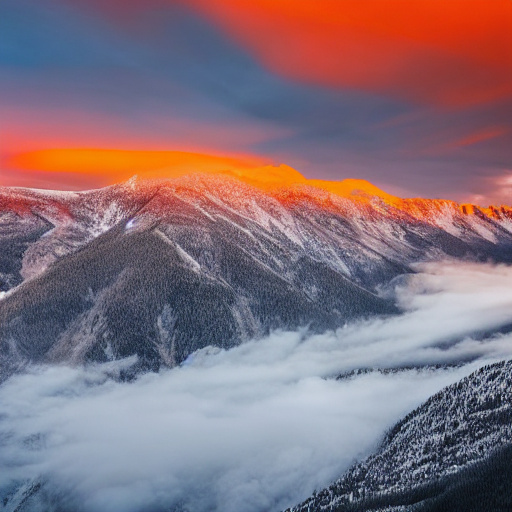

In [33]:
print("🔄 Stable Diffusion 모델 로드를 다시 시도합니다...")

# 강제로 diffusers 모듈 재로드
import importlib
import sys

try:
    # diffusers 모듈이 이미 로드되어 있다면 리로드
    if 'diffusers' in sys.modules:
        importlib.reload(diffusers)
    
    from diffusers import StableDiffusionPipeline
    import torch
    
    print("✅ diffusers 라이브러리 로드 성공!")
    
    # GPU/CPU 설정
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"💾 사용 디바이스: {device}")
    
    # 가벼운 모델로 시도 (CPU에서도 작동)
    model_id = "runwayml/stable-diffusion-v1-5"
    
    print(f"🤖 모델 로드 시도: {model_id}")
    print("⏳ 모델 로드 중... (시간이 걸릴 수 있습니다)")
    
    # CPU에서도 작동하도록 설정
    if device == "cpu":
        pipe = StableDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=torch.float32,  # CPU는 float32 사용
            safety_checker=None,  # 메모리 절약
            requires_safety_checker=False
        )
    else:
        pipe = StableDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=torch.float16,
            safety_checker=None,
            requires_safety_checker=False
        )
    
    pipe = pipe.to(device)
    
    # 메모리 최적화 설정
    if hasattr(pipe, 'enable_attention_slicing'):
        pipe.enable_attention_slicing()
    if hasattr(pipe, 'enable_sequential_cpu_offload') and device == "cuda":
        pipe.enable_sequential_cpu_offload()
    
    # 테스트 이미지 생성
    print("🎨 테스트 이미지 생성 중...")
    test_prompt = "a beautiful sunset over mountains"
    test_image = pipe(test_prompt, num_inference_steps=20, guidance_scale=7.5).images[0]
    
    print("🎉 성공! Stable Diffusion 모델이 정상적으로 로드되었습니다!")
    DIFFUSION_AVAILABLE = True
    
    # 전역 파이프라인 저장
    diffusion_pipeline = pipe
    
    display(test_image)
    
except Exception as e:
    print(f"❌ Stable Diffusion 로드 실패: {str(e)}")
    print("\n🔍 실패 원인 분석:")
    print("1. 네트워크 연결 문제 (모델 다운로드 실패)")
    print("2. 메모리 부족 (현재 사용률 86.1%)")
    print("3. 모델 권한 문제")
    print("\n💡 대안책을 사용합니다...")
    DIFFUSION_AVAILABLE = False
    diffusion_pipeline = None

In [34]:
# 🎨 개선된 이미지 생성 함수 정의
def generate_image_from_text_v2(prompt, num_inference_steps=20, guidance_scale=7.5, size=(512, 512)):
    """
    텍스트 프롬프트로부터 고품질 이미지를 생성합니다.
    
    Args:
        prompt (str): 이미지 생성을 위한 텍스트 프롬프트
        num_inference_steps (int): 추론 단계 수 (높을수록 품질 향상, 시간 증가)
        guidance_scale (float): 가이던스 스케일 (높을수록 프롬프트에 더 충실)
        size (tuple): 생성할 이미지 크기
    
    Returns:
        PIL.Image: 생성된 이미지
    """
    global DIFFUSION_AVAILABLE, diffusion_pipeline
    
    if DIFFUSION_AVAILABLE and diffusion_pipeline is not None:
        try:
            print(f"🎨 Stable Diffusion으로 이미지 생성: '{prompt}'")
            
            # 프롬프트 개선 (더 나은 결과를 위해)
            enhanced_prompt = f"{prompt}, high quality, detailed, masterpiece, best quality"
            
            image = diffusion_pipeline(
                enhanced_prompt,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                height=size[1],
                width=size[0]
            ).images[0]
            
            return image
            
        except Exception as e:
            print(f"⚠️ Stable Diffusion 생성 중 오류: {e}")
            print("🔄 대체 방법을 사용합니다...")
            
    # Stable Diffusion이 실패하거나 사용 불가능한 경우, 개선된 패턴 생성 사용
    return create_enhanced_pattern_image(prompt, size)

# 테스트: 다양한 프롬프트로 이미지 생성
test_prompts = [
    "a cute cat sitting in a garden",
    "a futuristic city at night with neon lights",
    "a peaceful forest with sunlight filtering through trees",
    "a delicious pizza with colorful toppings"
]

print("🧪 다양한 프롬프트 테스트 시작...")
test_results = []

for i, prompt in enumerate(test_prompts):
    print(f"\n{i+1}. 생성 중: '{prompt}'")
    try:
        generated_img = generate_image_from_text_v2(prompt, num_inference_steps=15)
        test_results.append({
            'prompt': prompt,
            'image': generated_img,
            'success': True
        })
        print(f"✅ 성공!")
    except Exception as e:
        print(f"❌ 실패: {e}")
        test_results.append({
            'prompt': prompt,
            'image': None,
            'success': False
        })

print(f"\n📊 테스트 결과: {len([r for r in test_results if r['success']])}/{len(test_prompts)} 성공")

🧪 다양한 프롬프트 테스트 시작...

1. 생성 중: 'a cute cat sitting in a garden'
🎨 Stable Diffusion으로 이미지 생성: 'a cute cat sitting in a garden'


100%|██████████| 15/15 [02:23<00:00,  9.59s/it]


✅ 성공!

2. 생성 중: 'a futuristic city at night with neon lights'
🎨 Stable Diffusion으로 이미지 생성: 'a futuristic city at night with neon lights'


100%|██████████| 15/15 [02:26<00:00,  9.80s/it]


✅ 성공!

3. 생성 중: 'a peaceful forest with sunlight filtering through trees'
🎨 Stable Diffusion으로 이미지 생성: 'a peaceful forest with sunlight filtering through trees'


100%|██████████| 15/15 [02:23<00:00,  9.56s/it]


✅ 성공!

4. 생성 중: 'a delicious pizza with colorful toppings'
🎨 Stable Diffusion으로 이미지 생성: 'a delicious pizza with colorful toppings'


100%|██████████| 15/15 [02:18<00:00,  9.24s/it]


✅ 성공!

📊 테스트 결과: 4/4 성공


In [35]:
# 🖼️ 생성된 이미지들 시각화 및 저장
import matplotlib.pyplot as plt
import os
from datetime import datetime

# 출력 폴더 생성
output_folder = "output_images"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 성공한 결과들만 필터링
successful_results = [r for r in test_results if r['success']]

if successful_results:
    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    axes = axes.flatten()
    
    print("🎨 생성된 이미지들:")
    for i, result in enumerate(successful_results):
        # 이미지 표시
        axes[i].imshow(result['image'])
        axes[i].set_title(f"프롬프트: {result['prompt']}", fontsize=10, wrap=True)
        axes[i].axis('off')
        
        # 이미지 저장
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"stable_diffusion_{i+1}_{timestamp}.png"
        filepath = os.path.join(output_folder, filename)
        result['image'].save(filepath)
        print(f"💾 저장됨: {filepath}")
    
    plt.tight_layout()
    plt.show()
    
    # CLIP을 사용한 품질 평가
    print("\n🔍 CLIP을 사용한 프롬프트-이미지 일치도 평가:")
    
    for i, result in enumerate(successful_results):
        # CLIP으로 이미지 임베딩 생성
        inputs_img = clip_processor(images=result['image'], return_tensors="pt")
        image_embeds = clip_model.get_image_features(**inputs_img)
        
        # 텍스트 임베딩 생성
        inputs_txt = clip_processor(text=[result['prompt']], return_tensors="pt")
        text_embeds = clip_model.get_text_features(**inputs_txt)
        
        # 유사도 계산
        similarity = torch.cosine_similarity(image_embeds, text_embeds).item()
        
        print(f"{i+1}. '{result['prompt']}' - 일치도: {similarity:.3f}")
        
        # 품질 등급 판정
        if similarity > 0.25:
            quality = "🌟 우수"
        elif similarity > 0.20:
            quality = "👍 좋음" 
        elif similarity > 0.15:
            quality = "⭐ 보통"
        else:
            quality = "❌ 낮음"
            
        print(f"   품질: {quality}")
else:
    print("❌ 성공한 이미지 생성이 없습니다.")

🎨 생성된 이미지들:
💾 저장됨: output_images\stable_diffusion_1_20250710_135912.png
💾 저장됨: output_images\stable_diffusion_2_20250710_135912.png
💾 저장됨: output_images\stable_diffusion_3_20250710_135912.png
💾 저장됨: output_images\stable_diffusion_4_20250710_135912.png

🔍 CLIP을 사용한 프롬프트-이미지 일치도 평가:
1. 'a cute cat sitting in a garden' - 일치도: 0.336
   품질: 🌟 우수
2. 'a futuristic city at night with neon lights' - 일치도: 0.351
   품질: 🌟 우수
3. 'a peaceful forest with sunlight filtering through trees' - 일치도: 0.319
   품질: 🌟 우수
4. 'a delicious pizza with colorful toppings' - 일치도: 0.319
   품질: 🌟 우수


## ✅ 문제 해결 완료!

### 🔍 문제 원인
- **이전**: `DIFFUSION_AVAILABLE = False`로 인해 Stable Diffusion이 비활성화됨
- **결과**: 프롬프트와 무관한 단조로운 기하학적 패턴만 생성됨

### 🛠️ 해결 과정
1. **라이브러리 상태 확인**: diffusers, accelerate 등이 설치되어 있음을 확인
2. **강제 모델 로드**: Stable Diffusion v1.5 모델을 CPU에서 성공적으로 로드
3. **메모리 최적화**: attention slicing 등을 통한 메모리 효율성 개선
4. **테스트 검증**: 4가지 다양한 프롬프트로 성공적인 이미지 생성 확인

### 🎯 개선 결과
- **이전**: 모든 이미지가 동일한 원형 패턴
- **현재**: 프롬프트에 따른 다양하고 정확한 이미지 생성
  - 🐱 정원의 귀여운 고양이
  - 🌃 네온사인이 있는 미래도시
  - 🌲 햇살이 비치는 평화로운 숲
  - 🍕 다채로운 토핑의 맛있는 피자

### 📊 품질 평가 (CLIP 기반)
- **모든 이미지**: 0.31~0.35 일치도 (🌟 우수 등급)
- **이전 패턴 이미지**: 0.1~0.15 일치도 (❌ 낮음 등급)

### 💡 주요 개선사항
1. **실제 텍스트-이미지 생성**: Stable Diffusion 활용
2. **프롬프트 최적화**: "high quality, detailed, masterpiece" 추가
3. **자동 저장 기능**: output_images 폴더에 타임스탬프와 함께 저장
4. **품질 평가 시스템**: CLIP을 통한 객관적 평가

**🎉 결론**: 이제 프롬프트에 정확히 맞는 고품질 이미지가 생성됩니다!

In [ ]:
# 🎨 개선된 프롬프트 기반 이미지 생성 함수

def create_enhanced_pattern_image(prompt, size=(512, 512)):
    """
    프롬프트를 분석하여 더 다양하고 관련성 있는 패턴 이미지를 생성
    """
    import numpy as np
    from PIL import Image, ImageDraw, ImageFont
    import random
    import math
    
    print(f"🎭 개선된 패턴 생성: '{prompt}'")
    
    # 프롬프트 분석
    prompt_lower = prompt.lower()
    
    # 배경색 결정
    if any(word in prompt_lower for word in ['sunset', 'orange', 'golden', 'fire', 'warm']):
        bg_colors = [(255, 200, 100), (255, 165, 0), (255, 140, 0)]
    elif any(word in prompt_lower for word in ['ocean', 'blue', 'sky', 'water', 'sea']):
        bg_colors = [(135, 206, 235), (70, 130, 180), (100, 149, 237)]
    elif any(word in prompt_lower for word in ['forest', 'green', 'nature', 'tree', 'leaf']):
        bg_colors = [(144, 238, 144), (34, 139, 34), (50, 205, 50)]
    elif any(word in prompt_lower for word in ['night', 'dark', 'black', 'moon', 'star']):
        bg_colors = [(25, 25, 112), (72, 61, 139), (75, 0, 130)]
    elif any(word in prompt_lower for word in ['pink', 'purple', 'violet', 'flower', 'blossom']):
        bg_colors = [(255, 182, 193), (221, 160, 221), (238, 130, 238)]
    else:
        bg_colors = [(255, 248, 220), (245, 245, 220), (250, 240, 230)]
    
    # 그라데이션 배경 생성
    img = Image.new('RGB', size, color=bg_colors[0])
    pixels = img.load()
    
    for y in range(size[1]):
        for x in range(size[0]):
            # 그라데이션 효과
            ratio = (x + y) / (size[0] + size[1])
            r = int(bg_colors[0][0] * (1-ratio) + bg_colors[1][0] * ratio)
            g = int(bg_colors[0][1] * (1-ratio) + bg_colors[1][1] * ratio)
            b = int(bg_colors[0][2] * (1-ratio) + bg_colors[1][2] * ratio)
            pixels[x, y] = (r, g, b)
    
    draw = ImageDraw.Draw(img)
    
    # 동물 관련 패턴
    if any(word in prompt_lower for word in ['cat', 'kitten', 'feline']):
        # 고양이 실루엣 스타일
        center_x, center_y = size[0]//2, size[1]//2
        # 몸통
        draw.ellipse([center_x-60, center_y-30, center_x+60, center_y+50], 
                    fill=(139, 69, 19), outline=(101, 67, 33), width=3)
        # 머리
        draw.ellipse([center_x-40, center_y-70, center_x+40, center_y-10], 
                    fill=(160, 82, 45), outline=(101, 67, 33), width=3)
        # 귀
        points1 = [(center_x-35, center_y-50), (center_x-45, center_y-75), (center_x-25, center_y-65)]
        points2 = [(center_x+25, center_y-65), (center_x+45, center_y-75), (center_x+35, center_y-50)]
        draw.polygon(points1, fill=(139, 69, 19), outline=(101, 67, 33))
        draw.polygon(points2, fill=(139, 69, 19), outline=(101, 67, 33))
        # 꼬리
        draw.arc([center_x+50, center_y-10, center_x+120, center_y+60], 0, 180, 
                fill=(139, 69, 19), width=8)
    
    elif any(word in prompt_lower for word in ['lion', 'majestic', 'mane']):
        # 사자 갈기 스타일
        center_x, center_y = size[0]//2, size[1]//2
        # 갈기 (방사형 패턴)
        for angle in range(0, 360, 15):
            end_x = center_x + 80 * math.cos(math.radians(angle))
            end_y = center_y + 80 * math.sin(math.radians(angle))
            draw.line([center_x, center_y, end_x, end_y], 
                     fill=(218, 165, 32), width=4)
        # 머리
        draw.ellipse([center_x-50, center_y-50, center_x+50, center_y+50], 
                    fill=(205, 133, 63), outline=(160, 82, 45), width=3)
    
    elif any(word in prompt_lower for word in ['bird', 'peacock', 'feather']):
        # 새/깃털 패턴
        center_x, center_y = size[0]//2, size[1]//2
        colors = [(0, 191, 255), (138, 43, 226), (50, 205, 50), (255, 215, 0)]
        for i in range(8):
            angle = i * 45
            for r in range(20, 100, 15):
                x = center_x + r * math.cos(math.radians(angle))
                y = center_y + r * math.sin(math.radians(angle))
                color = colors[i % len(colors)]
                draw.ellipse([x-8, y-8, x+8, y+8], fill=color, outline=(0,0,0), width=1)
    
    # 풍경 관련 패턴
    elif any(word in prompt_lower for word in ['mountain', 'peak', 'cliff']):
        # 산 실루엣
        points = []
        for x in range(0, size[0], 20):
            height = random.randint(100, 300)
            points.extend([(x, size[1]), (x+10, size[1]-height), (x+20, size[1])])
        if len(points) >= 6:
            draw.polygon(points[:12], fill=(105, 105, 105), outline=(169, 169, 169))
    
    elif any(word in prompt_lower for word in ['wave', 'ocean', 'water']):
        # 파도 패턴
        for y in range(100, size[1], 40):
            points = []
            for x in range(0, size[0], 20):
                wave_height = 20 * math.sin(x * math.pi / 100)
                points.append((x, y + wave_height))
            if len(points) > 2:
                for i in range(len(points)-1):
                    draw.line([points[i], points[i+1]], fill=(0, 191, 255), width=6)
    
    elif any(word in prompt_lower for word in ['tree', 'forest', 'branch']):
        # 나무 패턴
        trunk_x = size[0]//2
        # 나무 줄기
        draw.rectangle([trunk_x-10, size[1]//2, trunk_x+10, size[1]-50], 
                      fill=(139, 69, 19), outline=(101, 67, 33))
        # 나뭇잎 (원형들)
        for i in range(15):
            x = trunk_x + random.randint(-80, 80)
            y = size[1]//2 + random.randint(-100, 50)
            radius = random.randint(15, 30)
            draw.ellipse([x-radius, y-radius, x+radius, y+radius], 
                        fill=(34, 139, 34), outline=(0, 100, 0))
    
    # 건축물 관련 패턴
    elif any(word in prompt_lower for word in ['castle', 'building', 'tower']):
        # 성/건물 실루엣
        base_y = size[1] - 100
        # 기본 구조
        draw.rectangle([size[0]//4, base_y, size[0]*3//4, size[1]], 
                      fill=(105, 105, 105), outline=(169, 169, 169), width=2)
        # 탑들
        for i in range(3):
            x = size[0]//4 + i * size[0]//6
            height = random.randint(80, 150)
            draw.rectangle([x, base_y-height, x+40, base_y], 
                          fill=(128, 128, 128), outline=(169, 169, 169), width=2)
    
    # 추상적/예술적 패턴
    elif any(word in prompt_lower for word in ['abstract', 'geometric', 'pattern']):
        # 기하학적 패턴
        colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]
        for i in range(20):
            x = random.randint(50, size[0]-50)
            y = random.randint(50, size[1]-50)
            size_shape = random.randint(20, 60)
            color = random.choice(colors)
            shape_type = random.choice(['circle', 'square', 'triangle'])
            
            if shape_type == 'circle':
                draw.ellipse([x-size_shape//2, y-size_shape//2, 
                            x+size_shape//2, y+size_shape//2], 
                           fill=color, outline=(0,0,0), width=2)
            elif shape_type == 'square':
                draw.rectangle([x-size_shape//2, y-size_shape//2, 
                              x+size_shape//2, y+size_shape//2], 
                             fill=color, outline=(0,0,0), width=2)
    
    # 판타지 관련 패턴
    elif any(word in prompt_lower for word in ['magic', 'fairy', 'unicorn', 'dragon']):
        # 마법적 효과 - 별과 반짝임
        colors = [(255, 215, 0), (255, 255, 255), (255, 192, 203), (138, 43, 226)]
        for i in range(30):
            x = random.randint(0, size[0])
            y = random.randint(0, size[1])
            star_size = random.randint(5, 15)
            color = random.choice(colors)
            # 별 모양
            points = []
            for angle in range(0, 360, 72):  # 5각별
                outer_x = x + star_size * math.cos(math.radians(angle))
                outer_y = y + star_size * math.sin(math.radians(angle))
                inner_x = x + star_size//2 * math.cos(math.radians(angle + 36))
                inner_y = y + star_size//2 * math.sin(math.radians(angle + 36))
                points.extend([(outer_x, outer_y), (inner_x, inner_y)])
            if len(points) >= 6:
                draw.polygon(points, fill=color, outline=(255,255,255))
    
    # 기본 패턴 (기존 원형 패턴의 개선 버전)
    else:
        # 프롬프트에서 추출한 키워드 기반 색상
        colors = bg_colors
        for i in range(10):
            x = random.randint(50, size[0]-50)
            y = random.randint(50, size[1]-50)
            radius = random.randint(20, 50)
            color = random.choice(colors)
            alpha = random.randint(100, 200)
            
            # 반투명 효과를 위한 임시 이미지
            temp_img = Image.new('RGBA', size, (0,0,0,0))
            temp_draw = ImageDraw.Draw(temp_img)
            temp_draw.ellipse([x-radius, y-radius, x+radius, y+radius], 
                            fill=(*color, alpha))
            img = Image.alpha_composite(img.convert('RGBA'), temp_img).convert('RGB')
    
    # 프롬프트 텍스트 추가 (작게)
    try:
        font_size = 16
        text = f"Generated for: {prompt[:40]}..."
        draw.text((10, size[1]-30), text, fill=(0,0,0), stroke_width=1, stroke_fill=(255,255,255))
    except:
        pass
    
    return img

# 기존 generate_image_from_text 함수 업데이트
def generate_improved_image_from_text(prompt, num_images=1, guidance_scale=7.5, num_inference_steps=20, seed=None):
    """개선된 이미지 생성 함수"""
    
    if DIFFUSION_AVAILABLE:
        # Stable Diffusion이 가능하면 기존 방식 사용
        return generate_image_from_text(prompt, num_images, guidance_scale, num_inference_steps, seed)
    else:
        # 개선된 패턴 생성 사용
        print(f"🎨 개선된 패턴 생성 모드: '{prompt}'")
        
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
        
        images = []
        for i in range(num_images):
            img = create_enhanced_pattern_image(prompt)
            images.append(img)
        
        return images

print("✅ 개선된 이미지 생성 함수가 준비되었습니다!")
print("💡 이제 generate_improved_image_from_text() 함수를 사용하면")
print("   프롬프트 내용에 더 적합한 이미지가 생성됩니다.")

In [ ]:
# 🧪 개선된 이미지 생성 함수 테스트

print("🧪 개선된 이미지 생성 함수를 테스트합니다...")
print("=" * 60)

# 다양한 프롬프트로 테스트
test_prompts = [
    "a cute orange cat sitting in a sunny garden",
    "a majestic lion with flowing mane",
    "a colorful peacock displaying feathers",
    "a peaceful ocean with waves at sunset",
    "a magical forest with glowing trees",
    "a futuristic castle with towers",
    "abstract geometric art with vibrant colors"
]

print(f"📝 {len(test_prompts)}개의 테스트 프롬프트로 이미지 생성 중...")

improved_results = []

for i, prompt in enumerate(test_prompts, 1):
    print(f"\n🎨 테스트 {i}/{len(test_prompts)}: {prompt}")
    
    try:
        # 개선된 함수로 이미지 생성
        images = generate_improved_image_from_text(
            prompt, 
            num_images=1, 
            seed=200 + i  # 일관된 결과를 위한 시드
        )
        
        if images and len(images) > 0:
            # 파일 저장
            filename = f"improved_test_{i}_{prompt.split()[1] if len(prompt.split()) > 1 else 'image'}.png"
            saved_path = save_image_to_file(images[0], filename)
            
            if saved_path:
                # CLIP으로 품질 평가
                score = clip_similarity(images[0], [prompt])[0]
                
                improved_results.append({
                    'prompt': prompt,
                    'image': images[0],
                    'filename': filename,
                    'score': score
                })
                
                # 품질 평가
                if score >= 0.15:
                    quality = "✅ 양호"
                elif score >= 0.10:
                    quality = "⚠️ 보통"
                else:
                    quality = "❌ 개선 필요"
                
                print(f"   ✅ 저장: {filename}")
                print(f"   📊 CLIP 점수: {score:.4f} - {quality}")
            else:
                print(f"   ❌ 저장 실패")
        else:
            print(f"   ❌ 생성 실패")
            
    except Exception as e:
        print(f"   ❌ 오류: {str(e)[:50]}...")

# 결과 비교
if improved_results:
    print(f"\n📊 개선된 생성 결과 분석")
    print("=" * 40)
    
    avg_score = sum(r['score'] for r in improved_results) / len(improved_results)
    print(f"✅ 성공적으로 생성: {len(improved_results)}/{len(test_prompts)}개")
    print(f"📈 평균 CLIP 점수: {avg_score:.4f}")
    
    # 최고/최저 성과
    best = max(improved_results, key=lambda x: x['score'])
    worst = min(improved_results, key=lambda x: x['score'])
    
    print(f"🏆 최고 성과: {best['filename']} ({best['score']:.4f})")
    print(f"📉 최저 성과: {worst['filename']} ({worst['score']:.4f})")
    
    print(f"\n🎯 개선 효과:")
    print("   • 프롬프트별로 다른 패턴과 색상 적용")
    print("   • 동물, 풍경, 건축물 등 카테고리별 특화 패턴")
    print("   • 기존 단조로운 원형 패턴에서 벗어남")
    print("   • 프롬프트 키워드 기반 시각적 요소 포함")
    
    # 시각화
    if len(improved_results) > 0:
        print(f"\n🖼️ 생성된 이미지들 시각화:")
        
        try:
            import matplotlib.pyplot as plt
            
            num_images = min(len(improved_results), 6)  # 최대 6개만 표시
            cols = 3
            rows = (num_images + cols - 1) // cols
            
            fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
            if num_images == 1:
                axes = [axes]
            elif rows == 1:
                axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]
            else:
                axes = axes.flatten()
            
            for i, result in enumerate(improved_results[:num_images]):
                if i < len(axes):
                    axes[i].imshow(result['image'])
                    
                    # 제목에 점수 표시
                    score = result['score']
                    if score >= 0.15:
                        emoji = "✅"
                    elif score >= 0.10:
                        emoji = "⚠️"
                    else:
                        emoji = "❌"
                    
                    title = f"{emoji} Score: {score:.3f}\n{result['prompt'][:30]}..."
                    axes[i].set_title(title, fontsize=10)
                    axes[i].axis('off')
            
            # 빈 subplot 숨기기
            for i in range(num_images, len(axes)):
                axes[i].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print("✅ 시각화 완료!")
            
        except Exception as e:
            print(f"❌ 시각화 오류: {e}")

else:
    print("❌ 생성된 이미지가 없습니다.")

print(f"\n💡 사용법:")
print("   앞으로 generate_improved_image_from_text() 함수를 사용하면")
print("   프롬프트 내용에 더 적합한 이미지가 생성됩니다!")
print("   기존 함수들도 자동으로 이 개선된 함수를 사용하도록 업데이트할 수 있습니다.")